# cis-eQTL analysis
1. Sample size vs. eGene discovery
2. Explore gene length
3. Gene expression processing

After nominal pass:

4. Determine optimal #HCP from nominal associations
5. Visualize expression regressed by covariates, check batch effect
- Maybe: Relative log-expression RLE plots

After permutation pass:

6. Check beta approximated permutation pval
7. QTL TSS distance density plot
8. Compare sig feature across ancestries, upsetR, concordance of effects, etc.
9. Concordance with PEC, GTEx, RW
10. eGene types (protein_coding, lnc, etc.)
11. Conditional pass

In [1]:
suppressMessages(library(tidyverse))
suppressMessages(library(data.table))
suppressMessages(library(VennDiagram))
suppressMessages(library(UpSetR))
suppressMessages(library(patchwork))
suppressMessages(library(ggrepel))
# suppressMessages(library(DESeq2))
# suppressMessages(library(WGCNA))
# suppressMessages(library(sva))
# suppressMessages(library(edgeR))
library(wesanderson)
library(RColorBrewer)

In [2]:
setwd("~/project-gandalm/isoform_twas/eqtl_new/")

### 1: Sample size vs. #eGene

In [8]:
df <- data.frame("Study" = c("Walker",
                             "Obrien",
                             "Werling",
                             "BrainSeq_Phase1",
                             "GTEx_v7_cortex",
                             "GTEx_v8_cortex",
                             "PsychENCODE",
                             "PsychENCODE",
                             "Fetal_mega",
                             "Fetal_mega"),
                "sample" = c(201, 120, 112, 412, 136, 205, 1387, 1387, 629, 629),
                "gene" = c(6546, 1329, 4378, 18416, 6146, 9082, 32944, 16295, 22850, 10094),
                "Mode" = c(rep("Permutation", 2), rep("Nominal",2), rep("Permutation", 2), 
                           rep(c("Nominal", "Permutation"), 2)),
                "Age" = c(rep("Fetal", 3), rep("Adult", 5), rep("Fetal", 2)))
df

Study,sample,gene,Mode,Age
<fct>,<dbl>,<dbl>,<fct>,<fct>
Walker,201,6546,Permutation,Fetal
Obrien,120,1329,Permutation,Fetal
Werling,112,4378,Nominal,Fetal
BrainSeq_Phase1,412,18416,Nominal,Adult
GTEx_v7_cortex,136,6146,Permutation,Adult
GTEx_v8_cortex,205,9082,Permutation,Adult
PsychENCODE,1387,32944,Nominal,Adult
PsychENCODE,1387,16295,Permutation,Adult
Fetal_mega,629,22850,Nominal,Fetal


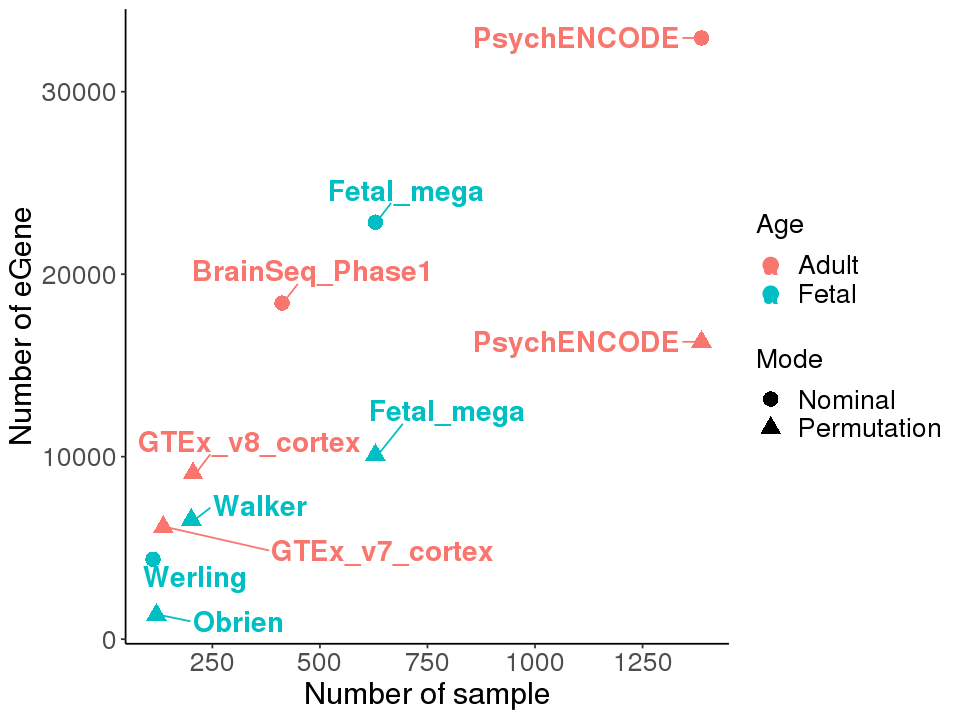

In [16]:
options(repr.plot.width = 8, repr.plot.height = 6)
p <- ggplot(df, aes(x = sample, y = gene, label = Study, color = Age, shape = Mode)) +
    geom_point(size = 4) +
    labs(x = "Number of sample",
         y = "Number of eGene") +
    theme_classic() +
    theme(axis.text = element_text(size = 16),
          axis.title = element_text(size = 18),
          plot.title = element_text(size = 18, face = "bold", hjust = 0.5),
          legend.position = "right",
         legend.title = element_text(size = 16),
         legend.text = element_text(size = 16)) +
    geom_text_repel(size = 6, min.segment.length = 0,
                    box.padding = 0.5, point.padding = 0.4, fontface = "bold") +
    scale_x_continuous(breaks = seq(0, 1500, by = 250)) 
p

In [17]:
ggsave("figures/studies.png", p, height = 6, width = 8)

### 2: Explore gene length. Is 1Mb cis window good?

In [2]:
dat <- fread("data/gene.counts.processed.tsv", data.table = F)

Warning message in fread("~/project-gandalm/isoform_twas/eqtl_new/data/gene.counts.processed.tsv", :
“Detected 642 column names but the data has 643 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”


In [20]:
gencode <- fread("~/project-gandalm/isoform_twas/salmon/gencode.gene.noVersion.tsv", data.table = F)

In [4]:
head(dat)

,V1,1474,1496,1500,1502,1507,1511,1513,1525,1531,⋯,1558,1607,1707.1,1835,1851,1890,1923,2193,849,898
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ENSG00000000419,9.841250,9.177032,9.470526,8.889949,8.859147,9.869163,9.518204,9.473462,9.167232,⋯,9.313513,9.641778,9.103888,10.016891,9.717624,8.875114,9.177785,8.908476,8.818348,8.781627
2,ENSG00000000457,9.240075,9.345108,9.409079,9.360622,9.364026,9.298172,9.307230,9.450109,8.744793,⋯,9.248521,9.034432,8.909848,9.451742,8.936577,8.905937,9.151401,9.047019,9.203484,8.959639
3,ENSG00000000460,9.958170,8.602040,9.494180,8.527582,8.842721,9.494976,8.963676,8.468142,8.140846,⋯,8.492937,8.813609,8.058658,9.023049,8.393364,8.574984,8.375750,8.231860,8.295203,7.960872
4,ENSG00000000938,3.785048,4.625944,4.389944,4.436550,5.329249,4.997359,4.236019,5.190552,3.709355,⋯,4.571956,6.526651,4.429746,4.292569,5.237749,4.572319,4.983927,4.248742,5.407510,5.803780
5,ENSG00000000971,6.613001,7.545237,7.117006,5.820229,8.248171,6.480063,8.364863,7.103860,5.862169,⋯,6.175374,10.131938,8.967814,6.368925,9.193750,9.434200,8.454724,8.998835,7.558015,9.445345
6,ENSG00000001036,8.293299,8.657986,8.622531,7.847619,8.547067,8.458103,8.107981,8.436925,8.011778,⋯,8.184961,8.792488,8.580463,8.514031,8.656127,8.288406,8.255862,8.481300,8.437080,8.845259


In [5]:
head(gencode)

,V1,V2,V3,V4,V5
,<chr>,<int>,<int>,<chr>,<chr>
1,chr1,11869,14409,+,ENSG00000223972
2,chr1,14404,29570,-,ENSG00000227232
3,chr1,29554,31109,+,ENSG00000243485
4,chr1,34554,36081,-,ENSG00000237613
5,chr1,52473,53312,+,ENSG00000268020
6,chr1,57598,64116,+,ENSG00000240361


In [6]:
dim(gencode)

[1] 62486     5

In [21]:
gencode <- gencode %>% filter(V5 %in% dat$V1)
dim(gencode)

[1] 31947     5

In [22]:
gencode <- gencode %>% mutate(length=V3-V2)
head(gencode)

,V1,V2,V3,V4,V5,length
,<chr>,<int>,<int>,<chr>,<chr>,<int>
1,chr1,11869,14409,+,ENSG00000223972,2540
2,chr1,14404,29570,-,ENSG00000227232,15166
3,chr1,29554,31109,+,ENSG00000243485,1555
4,chr1,34554,36081,-,ENSG00000237613,1527
5,chr1,89295,133723,-,ENSG00000238009,44428
6,chr1,89551,91105,-,ENSG00000239945,1554


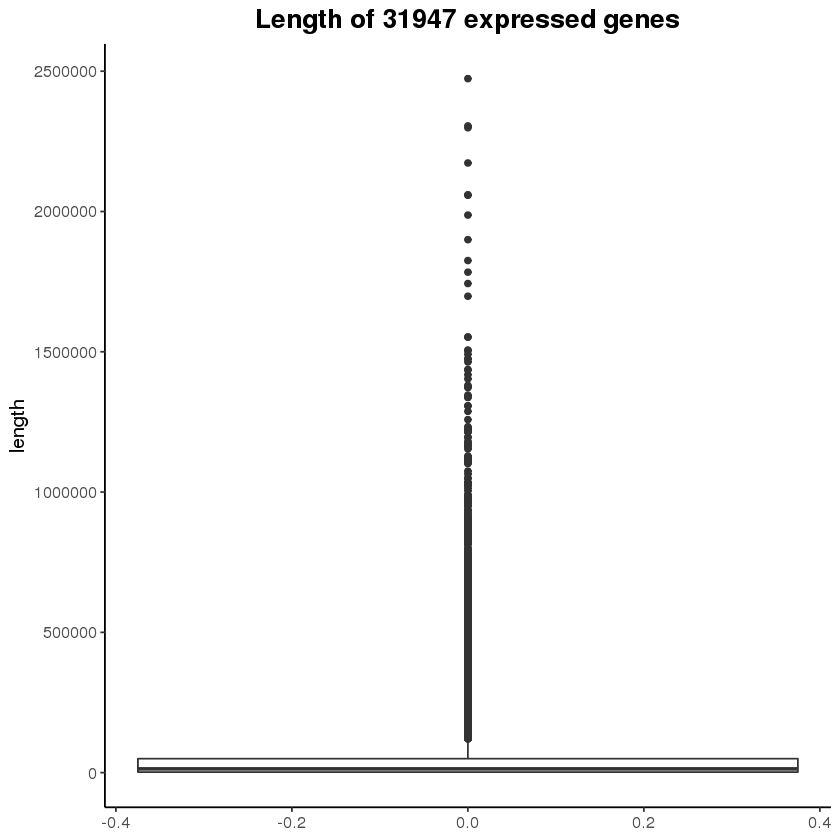

In [14]:
p <- ggplot(gencode, aes(y=length)) +
#     geom_density(color="black") +
    geom_boxplot() +
    labs(title = "Length of 31947 expressed genes") +
    theme_classic() +
    theme(axis.text = element_text(size=10),
        axis.title = element_text(size=12),
        plot.title = element_text(size=16, face="bold", hjust = 0.5),
        plot.subtitle = element_text(size=14, hjust = 0.5))
p

In [23]:
range(gencode$length)

[1]      51 2473539

In [17]:
gencode[gencode$length==2473539,]

,V1,V2,V3,V4,V5,length
,<chr>,<int>,<int>,<chr>,<chr>,<int>
24149,chr16,5289803,7763342,+,ENSG00000078328,2473539


In [24]:
sum(gencode$length > 1000000)

[1] 74

In [3]:
# gencode %>% filter(length > 1000000)

### 3: Expression processing

In [49]:
datExpr <- fread("../salmon/expression.final/gene.noVersion.scaled.counts.tsv", data.table = F)
gtf <- fread("../salmon/gencode.gene.noVersion.tsv", data.table = F)

Warning message in fread("../salmon/expression.final/gene.noVersion.scaled.counts.tsv", :
“Detected 654 column names but the data has 655 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”


In [50]:
which(names(datExpr) == "1707")

[1]  41 647

In [52]:
# remove chrM, chrX, chrY
# walker and hdbr duplicate 1707
# make hdbr 1707.1
names(datExpr)[647] <- "1707.1"
gtf <- gtf %>% filter(!(V1 %in% c("chrX","chrY","chrM")))
datExpr <- datExpr %>% filter(V1 %in% gtf$V5)
gtf <- gtf %>% filter(V5 %in% datExpr$V1)

rownames(datExpr) <- datExpr$V1
datExpr <- datExpr[,-1]
datExpr <- round(datExpr)

In [53]:
dim(gtf)
dim(datExpr)

[1] 58965     5

[1] 58965   654

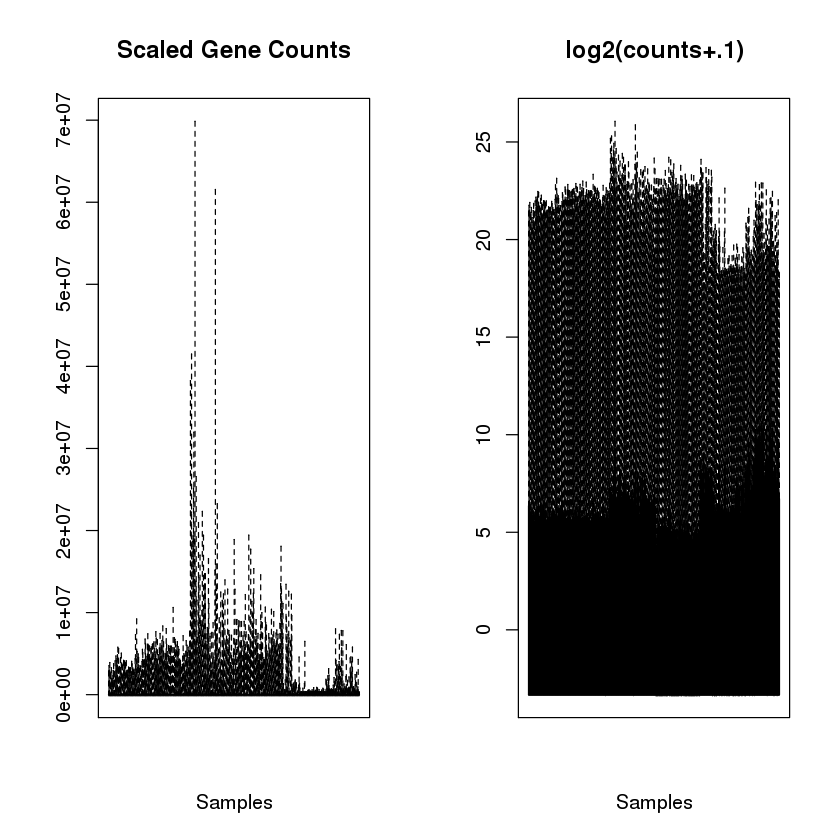

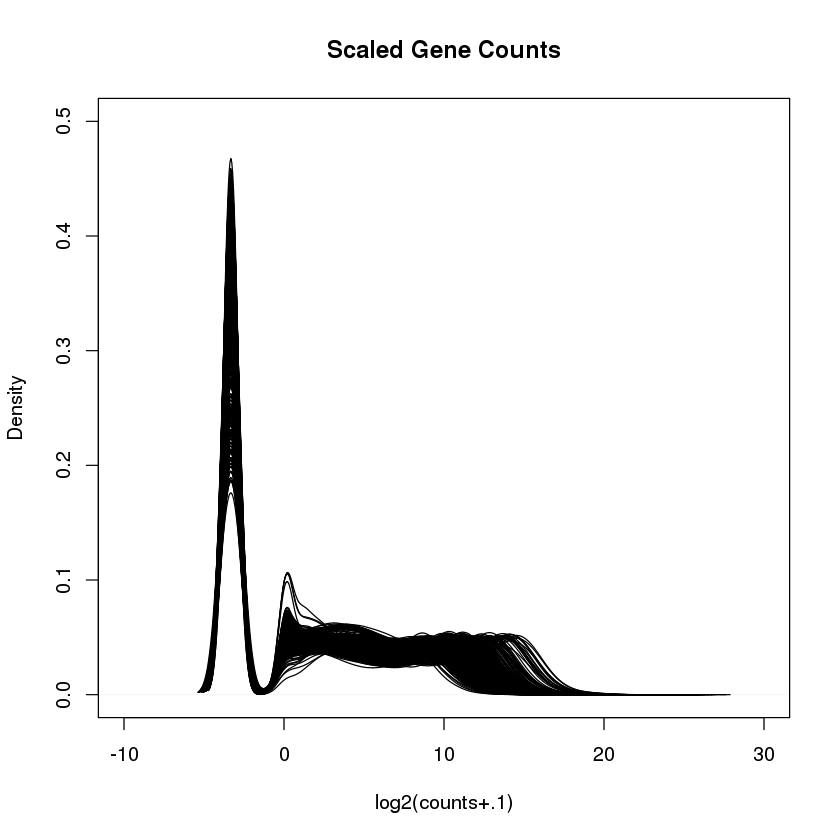

In [36]:
# View the distribution of expression for each sample.
# box plot, looking for big differences in read depth (raw counts), symmetry in distribution across samples
par(mfrow=c(1,2))
boxplot(datExpr, range = 0, main = 'Scaled Gene Counts', xlab = 'Samples', xaxt = "n")
boxplot(log2(.1+datExpr), range = 0, main = 'log2(counts+.1)', xlab = 'Samples', xaxt = "n")

# Histogram/density plot
# Look for: how well do the distributions line up, outlier samples, zero counts
par(mfrow=c(1,1))
i <- 1
plot(density(log2(.1+datExpr[,i])), main = 'Scaled Gene Counts', xlab = 'log2(counts+.1)', 
     xlim = c(-10,30), ylim = c(0,0.5))
for(i in 2:ncol(datExpr)){
  lines(density(log2(.1+datExpr[,i])))
}

In [74]:
# Remove lowly expressed
datExpr.tpm <- fread("../salmon/expression.final/gene.noVersion.TPM.tsv", data.table = F)
names(datExpr.tpm)[647] <- "1707.1"
datExpr.tpm <- datExpr.tpm %>% filter(V1 %in% gtf$V5)
rownames(datExpr.tpm) <- datExpr.tpm$V1
datExpr.tpm <- datExpr.tpm[,-1]

Warning message in fread("../salmon/expression.final/gene.noVersion.TPM.tsv", data.table = F):
“Detected 654 column names but the data has 655 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”


In [12]:
# Select cutoff
# cutoff = 0
cut0_df <- data.frame("subjProportion" = seq(0.1, 1, 0.1),
                      "numFeature" = NA)
for(i in seq(0.1, 1, 0.1)) {
  keep <- (rowSums(datExpr.tpm > 0)) > i*dim(datExpr.tpm)[2]
  cut0_df[which(cut0_df$subjProportion==i),"numFeature"] <- sum(keep)
}
cut0_df$cutoff <- rep(0, 10)

# cutoff = 0.1
cut1_df <- data.frame("subjProportion" = seq(0.1, 1, 0.1),
                      "numFeature" = NA)
for(i in seq(0.1, 1, 0.1)) {
  keep <- (rowSums(datExpr.tpm > .1)) > i*dim(datExpr.tpm)[2]
  cut1_df[which(cut1_df$subjProportion==i),"numFeature"] <- sum(keep)
}
cut1_df$cutoff <- rep(.1, 10)

# cutoff = 0.5
cut5_df <- data.frame("subjProportion" = seq(0.1, 1, 0.1),
                      "numFeature" = NA)
for(i in seq(0.1, 1, 0.1)) {
  keep <- (rowSums(datExpr.tpm > .5)) > i*dim(datExpr.tpm)[2]
  cut5_df[which(cut5_df$subjProportion==i),"numFeature"] <- sum(keep)
}
cut5_df$cutoff <- rep(.5, 10)

# cutoff = 1
cut10_df <- data.frame("subjProportion" = seq(0.1, 1, 0.1),
                      "numFeature" = NA)
for(i in seq(0.1, 1, 0.1)) {
  keep <- (rowSums(datExpr.tpm > 1)) > i*dim(datExpr.tpm)[2]
  cut10_df[which(cut10_df$subjProportion==i),"numFeature"] <- sum(keep)
}
cut10_df$cutoff <- rep(1, 10)


cut_df <- rbind(cut0_df, cut1_df, cut5_df, cut10_df)
cut_df$cutoff <- as.factor(cut_df$cutoff)

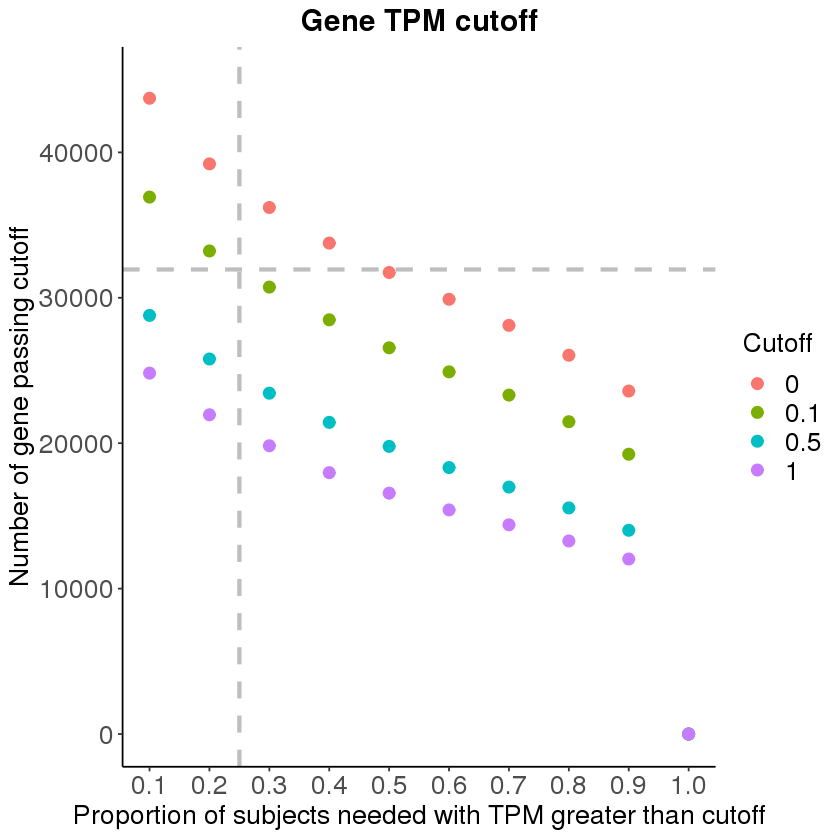

In [27]:
p <- ggplot(cut_df, aes(x = subjProportion, y = numFeature, color = cutoff)) +
  geom_point(size = 3) +
  labs(x = "Proportion of subjects needed with TPM greater than cutoff",
       y = "Number of gene passing cutoff",
       title = "Gene TPM cutoff",
       color = "Cutoff") +
  theme_classic() +
  theme(axis.text = element_text(size=16),
        axis.title = element_text(size=16),
        plot.title = element_text(size=18, face="bold", hjust = 0.5),
        legend.title = element_text(size=16),
         legend.text = element_text(size=16)) +
  scale_x_continuous(breaks = seq(0,1,0.1)) +
  ylim(0,45000) +
  geom_vline(xintercept = 0.25, linetype = "dashed", color = "grey", size = 1.2) +
  geom_hline(yintercept = 31947, linetype = "dashed", color = "grey", size = 1.2)
p

In [25]:
ggsave("figures/cutoff.png", p, width = 6, height = 6)

In [54]:
# cutoff=0.1, 25% subjects
keep <- (rowSums(datExpr.tpm > .1)) > 0.25*ncol(datExpr.tpm)
table(keep)

keep
FALSE  TRUE 
27018 31947 

In [55]:
datExpr <- datExpr[keep,]

In [76]:
datExpr.tpm <- datExpr.tpm[keep,]
dim(datExpr.tpm)

[1] 31947   654

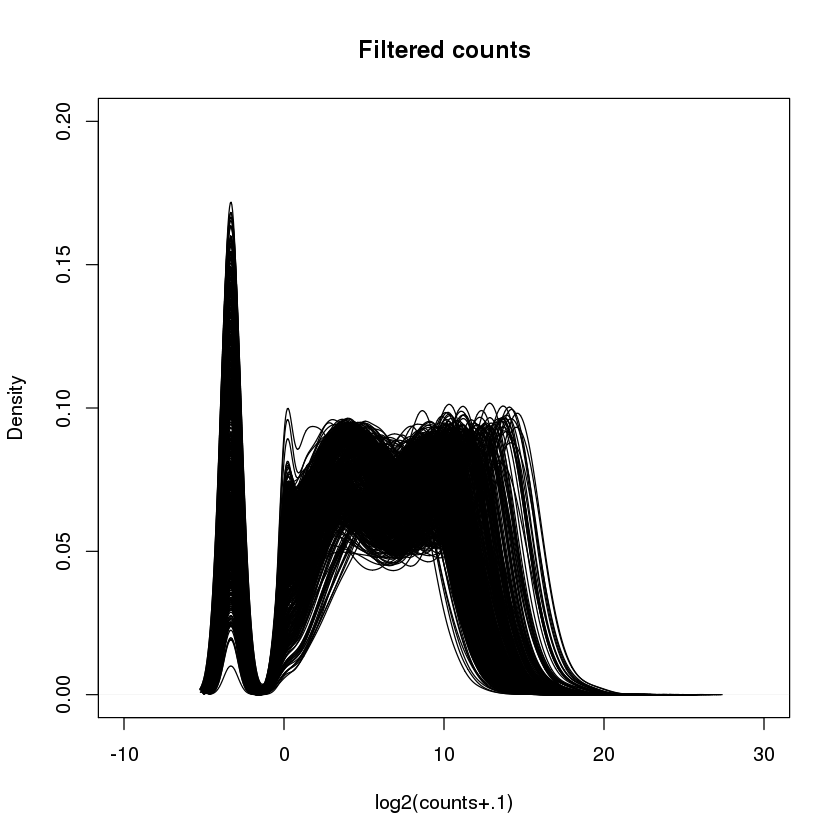

In [31]:
# Histogram for filtered 
i <- 1
plot(density(log2(.1+datExpr[,i])), main = "Filtered counts", xlab = "log2(counts+.1)", 
     xlim = c(-10,30), ylim = c(0,0.2))
for(i in 2:ncol(datExpr)){
  lines(density(log2(.1+datExpr[,i])))
}

- TMM calculates scaling factors
- Original library size * scaling factor = “effective library size”
- Cpm (counts, log=T)
- Normalized by library size/depth

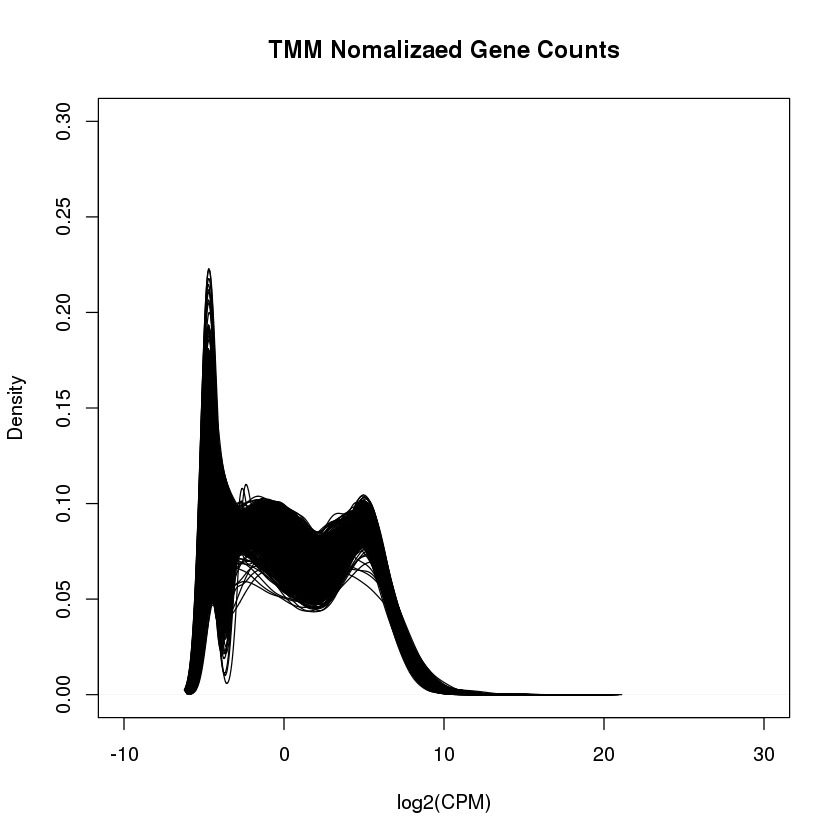

In [56]:
# Normalization
# 1. TMM, cpm
counts <- DGEList(datExpr)
counts <- calcNormFactors(counts, method = 'TMM')  #Perform Trimmed Mean of M-value (TMM) library size normalization
datExpr.cpm <- as.data.frame(cpm(counts, log=T))

i <- 1
plot(density(datExpr.cpm[,i]), main = "TMM Nomalizaed Gene Counts", xlab="log2(CPM)", 
     xlim = c(-10, 30), ylim = c(0,0.3))
for(i in 2:ncol(datExpr.cpm)){
  lines(density(datExpr.cpm[,i]))
}

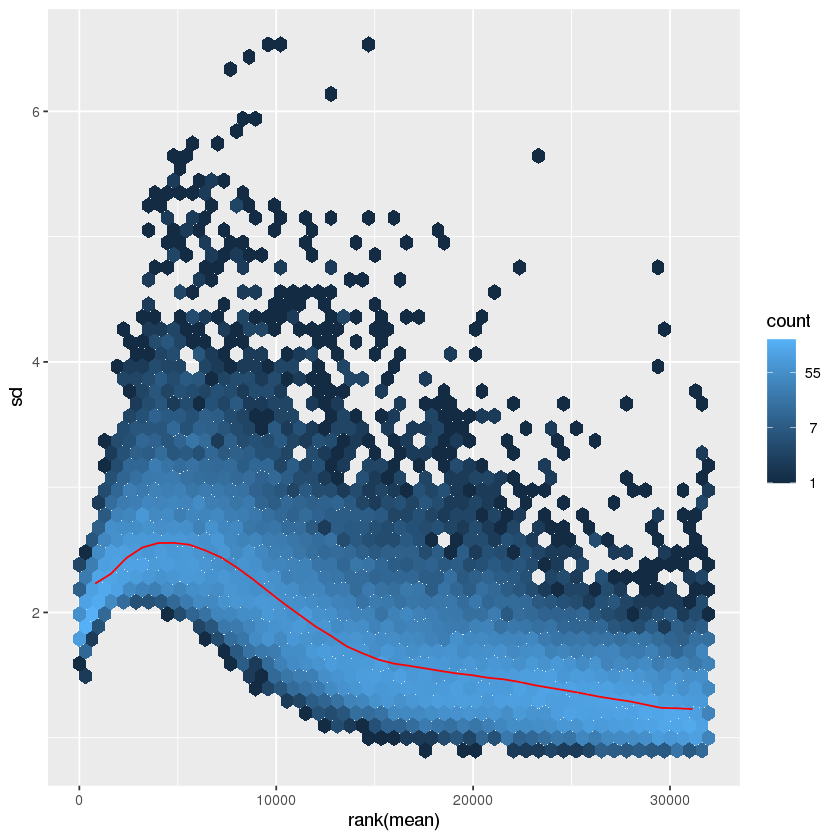

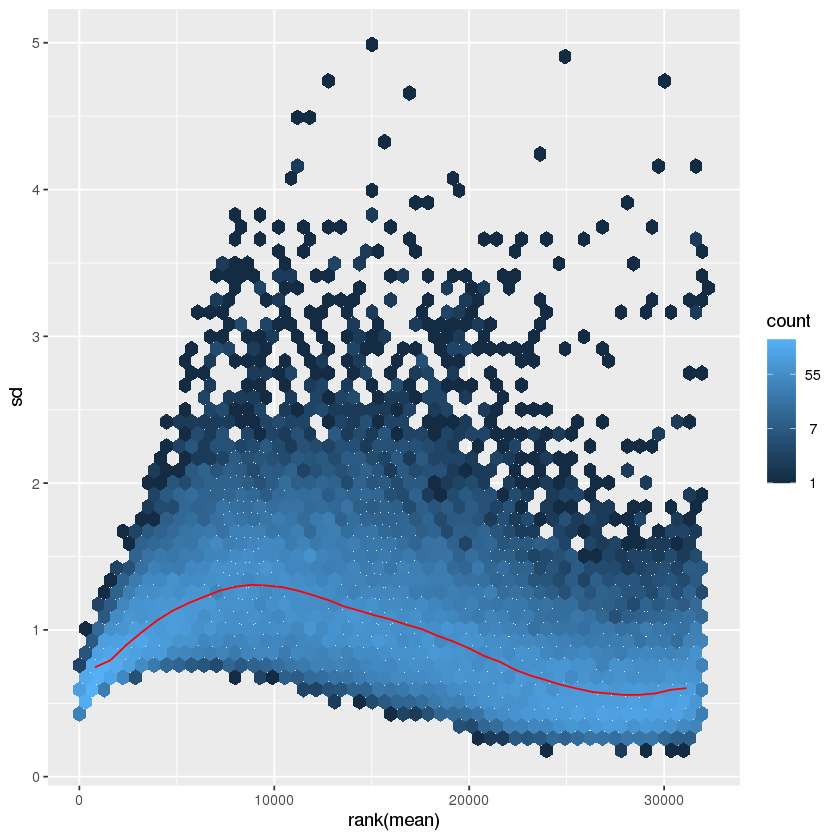

In [59]:
# 2. variance stabilizing transformation (normalize by depth, and stabilize variance)

# before variance stabilized
library(vsn)
library(hexbin)

meanSdPlot(as.matrix(log2(.1+datExpr)))
meanSdPlot(as.matrix(datExpr.cpm))

converting counts to integer mode



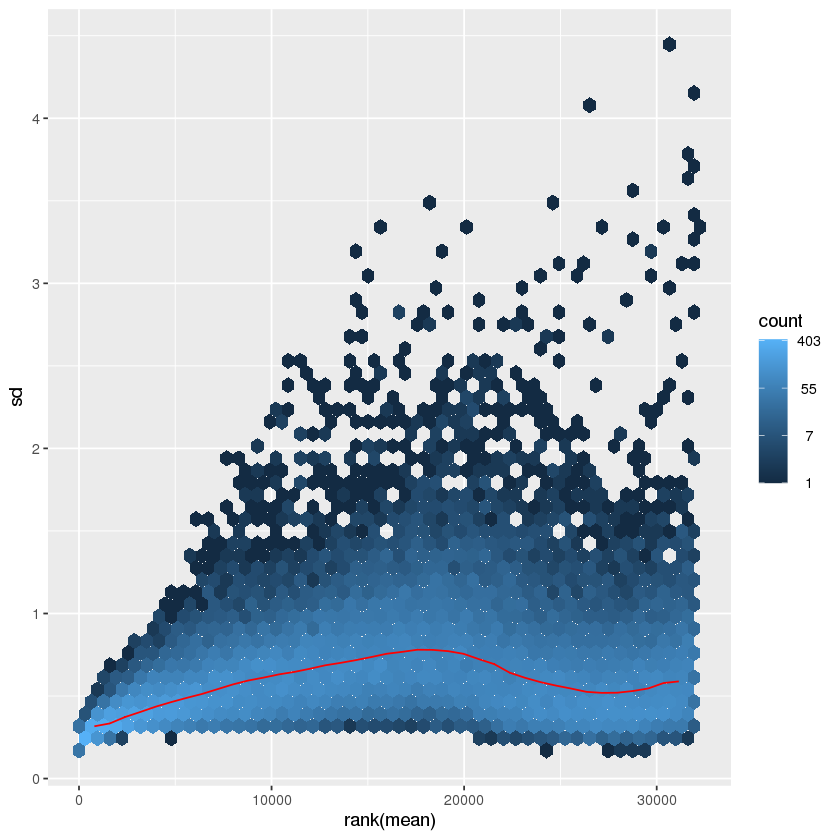

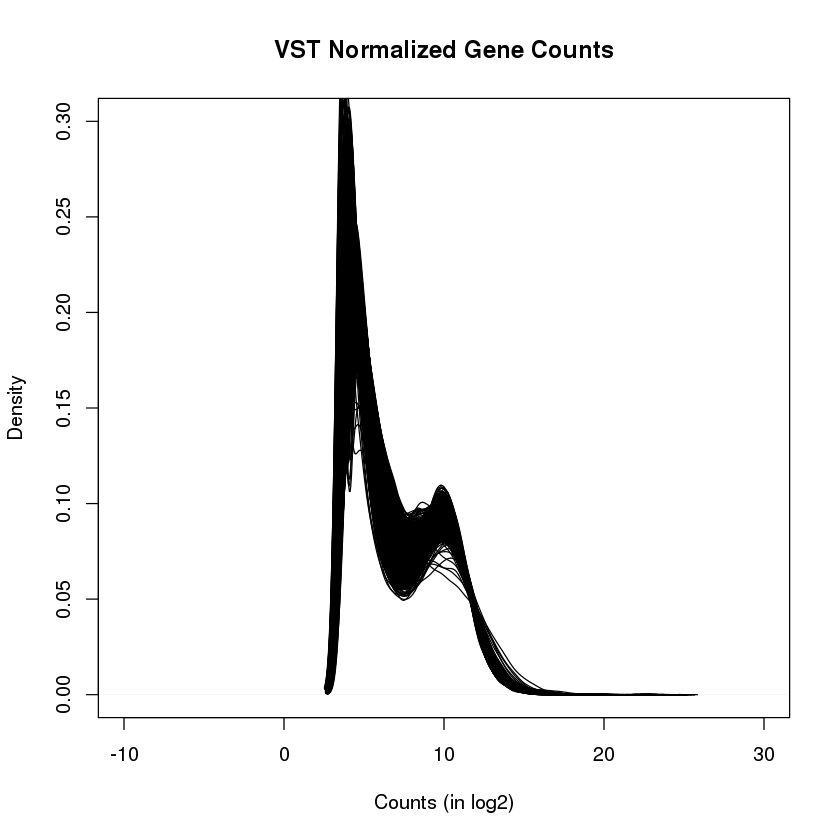

In [68]:
# Because there's no design matrix, input is a count matrix not a DESeqDataSet
# blind = T or F is no difference
# vst is using a subset of genes to estimate dispersion, faster
# use varianceStabilizingTransformation in actual script
datExpr.vst <- vst(as.matrix(datExpr), blind = TRUE)
meanSdPlot(as.matrix(datExpr.vst))
datExpr.vst <- as.data.frame(datExpr.vst)

# Density after VST normalization
i <- 1
plot(density(datExpr.vst[,i]), main = "VST Normalized Gene Counts", xlab = "Counts (in log2)", 
     xlim = c(-10,30), ylim = c(0,0.3b))
for(i in 2:ncol(datExpr.vst)){
  lines(density(datExpr.vst[,i]))
}

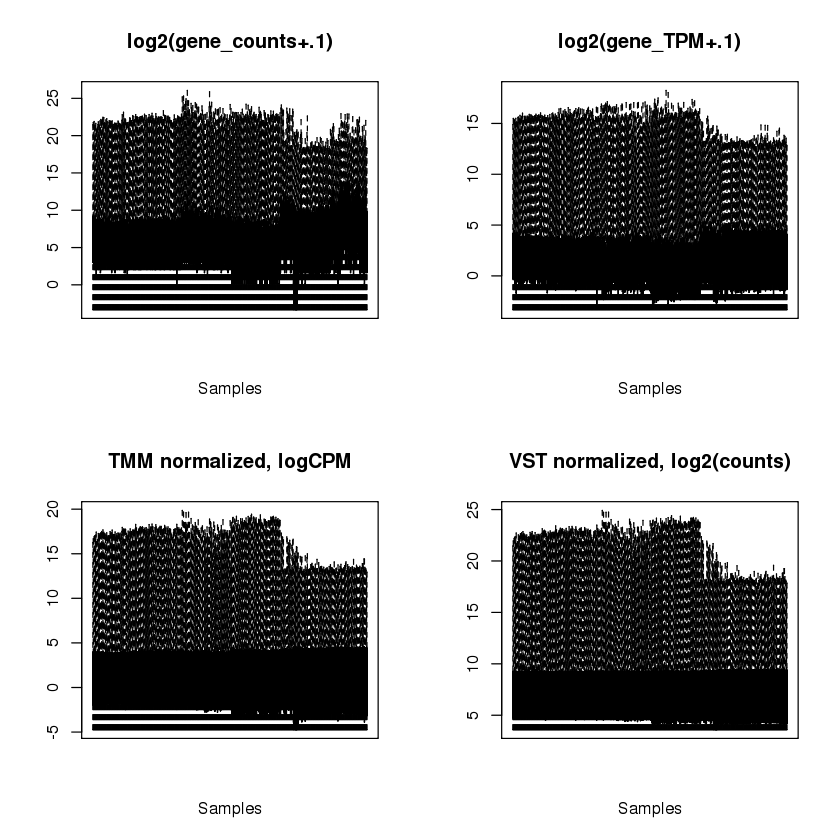

In [77]:
# check depth normalization, in log2 scale
par(mfrow=c(2, 2))
boxplot(log2(.1+datExpr), range=0, main = "log2(gene_counts+.1)", xlab="Samples",xaxt="n")
boxplot(log2(.1+datExpr.tpm), range=0, main = "log2(gene_TPM+.1)", xlab="Samples",xaxt="n")
boxplot(datExpr.cpm, range=0, main = "TMM normalized, logCPM", xlab="Samples",xaxt="n")
boxplot(datExpr.vst, range=0, main = "VST normalized, log2(counts)", xlab="Samples",xaxt="n")

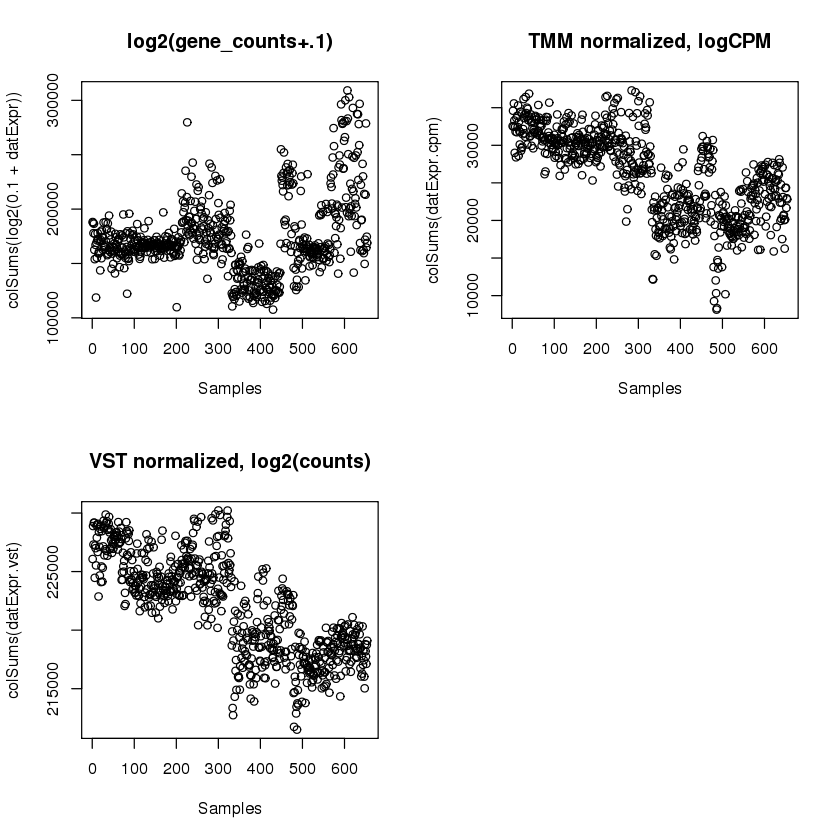

In [81]:
par(mfrow=c(2, 2))
plot(colSums(log2(.1+datExpr)), main = "log2(gene_counts+.1)", xlab="Samples")
# plot(colSums(log2(.1+datExpr.tpm)), main = "log2(gene_TPM+.1)", xlab="Samples")
# plot(colSums(datExpr.tpm), main = "gene_TPM", xlab="Samples")
plot(colSums(datExpr.cpm), main = "TMM normalized, logCPM", xlab = "Samples")
plot(colSums(datExpr.vst), main = "VST normalized, log2(counts)", xlab = "Samples")

In [88]:
# Outlier detection
normadj <- adjacency(datExpr.vst,type = 'signed',corFnc = 'bicor')   #Calculate network adjacency
netsummary <- fundamentalNetworkConcepts(normadj)
C <- netsummary$Connectivity   #Extract connectivity of each sample
Z.C <- (C-mean(C))/sqrt(var(C))   #Covert to Z-score

par(mfrow=c(1,1))
png("figures/outlier.png", width = 300, height = 300)
plot(1:length(Z.C), Z.C, main = "Outlier Plot", xlab = "Samples",ylab = "Connectivity Z Score", cex.main = 1.2)
abline(h=-3, col="red")
dev.off()

png 
  2

In [83]:
outliers <- (Z.C < -3)
outlier.df <- data.frame(c(which(outliers)))
outlier.df$c.which.outliers.. <- rownames(outlier.df)
outlier.df

,c.which.outliers..
,<chr>
17111,17111
HSB194,HSB194
Br2403,Br2403
Br2410,Br2410
Br2411,Br2411
Br2416,Br2416
1092,1092
11334,11334
11373,11373


In [89]:
datExpr.final <- datExpr.vst
datExpr.final <- datExpr.final[,!outliers]
dim(datExpr.final)

[1] 31947   642

In [90]:
geno_subj_dir <- "../genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/"
walker <- read.table(paste0(geno_subj_dir, "geno_subj_walker.txt"))
obrien <-read.table(paste0(geno_subj_dir, "geno_subj_obrien.txt"))
werling <-read.table(paste0(geno_subj_dir, "geno_subj_werling.txt"))
hdbr <- read.table(paste0(geno_subj_dir, "geno_subj_hdbr.txt"))
libd <- read.table(paste0(geno_subj_dir, "geno_subj_libd.txt"))

data.batch <- c()

for (i in 1:ncol(datExpr.final)) {
  sample <- colnames(datExpr.final)[i]
  if (sample %in% walker[,1]) {
    data.batch[i] <- 1
  }
  if (sample %in% obrien[,1]) {
    data.batch[i] <- 2
  }
  if (sample %in% werling[,1]) {
    data.batch[i] <- 3
  }
  if (sample %in% hdbr[,1]) {
    data.batch[i] <- 4
  }
  if (sample %in% libd[,1]) {
    data.batch[i] <- 5
  }
}

exprMat <- as.matrix(datExpr.final)
combat_expr <- ComBat(dat = exprMat, batch = data.batch, mod = NULL, par.prior = TRUE, prior.plots = FALSE)
combat_expr <- as.data.frame(combat_expr)

Found5batches

Adjusting for0covariate(s) or covariate level(s)



Standardizing Data across genes


Fitting L/S model and finding priors

Finding parametric adjustments

Adjusting the Data




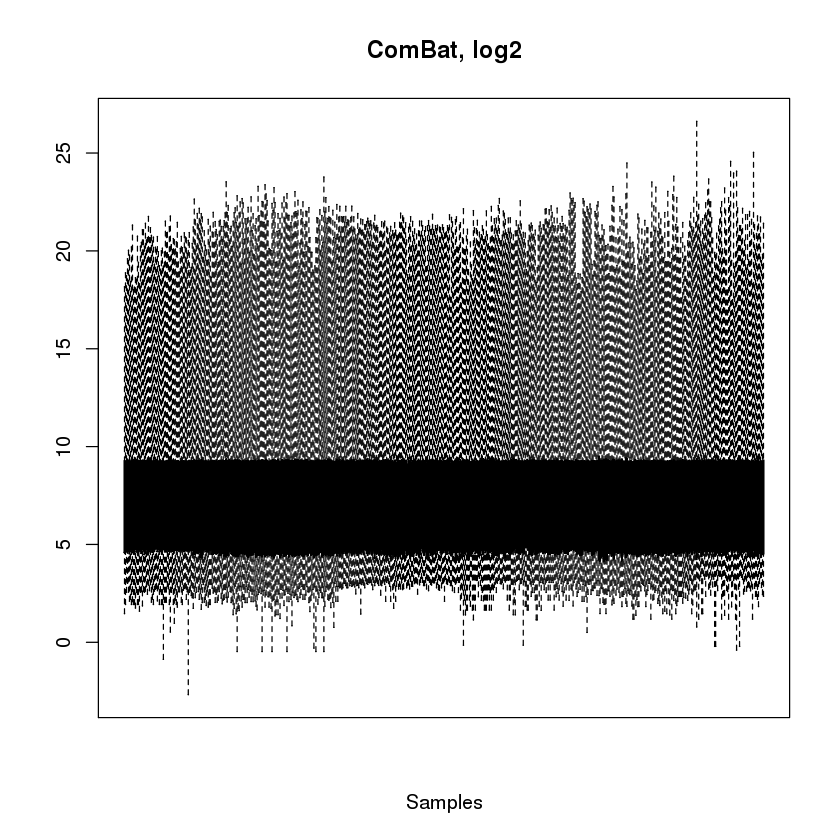

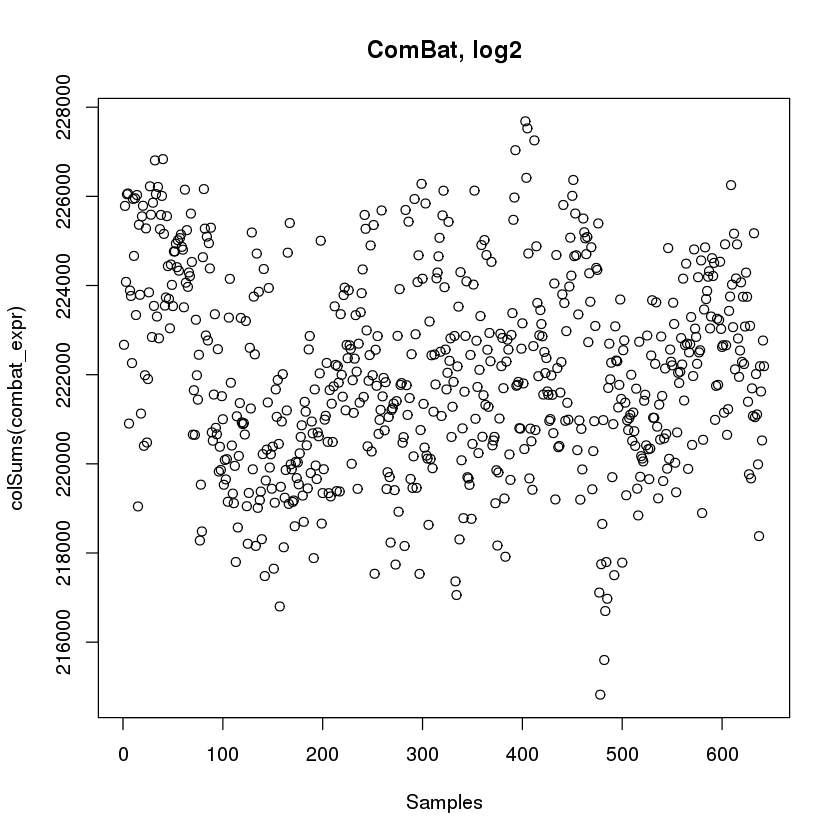

In [92]:
boxplot(combat_expr, range=0, main = "ComBat, log2", xlab="Samples", xaxt="n")
plot(colSums(combat_expr), main = "ComBat, log2", xlab = "Samples")

### 4: Optimal number of HCP

#### Mixed ancestry

In [21]:
df <- data.frame("HCP" = seq(10, 100, 10),
                 "Count" = NA)
for (i in seq(10, 100, 10)) {
    df[i/10, "Count"] <- read.table(paste0("results/mixed_nominal_", i, 
                                           "hcp/significant_feature_count.txt"))[,1]
}

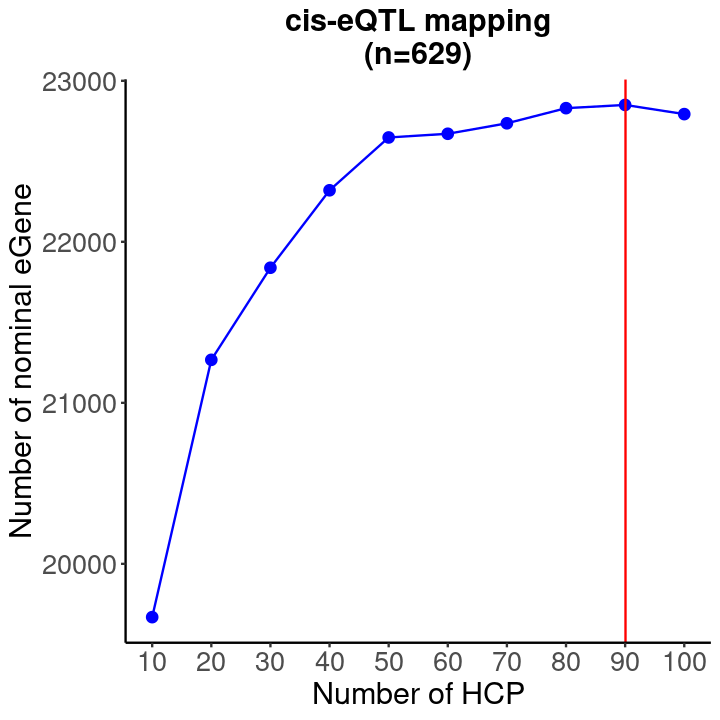

In [22]:
options(repr.plot.width=6, repr.plot.height=6)

p1 <- ggplot(df) + 
    geom_point(aes(x=HCP, y=Count), color = "blue", size = 2.5) +
    geom_line(aes(x=HCP, y=Count), color = "blue") +
    scale_x_continuous(breaks = seq(0,110,by = 10)) +
    geom_vline(xintercept = 90, color = "red") +
    labs(title = "cis-eQTL mapping\n(n=629)", x = "Number of HCP", y = "Number of nominal eGene") +
    theme_classic() +
    theme(axis.text = element_text(size=16),
          axis.title = element_text(size=18),
          plot.title = element_text(size=18, face="bold", hjust = 0.5))
p1

In [23]:
ggsave("figures/temp.pdf", p1, width = 6, height = 6)

#### EUR

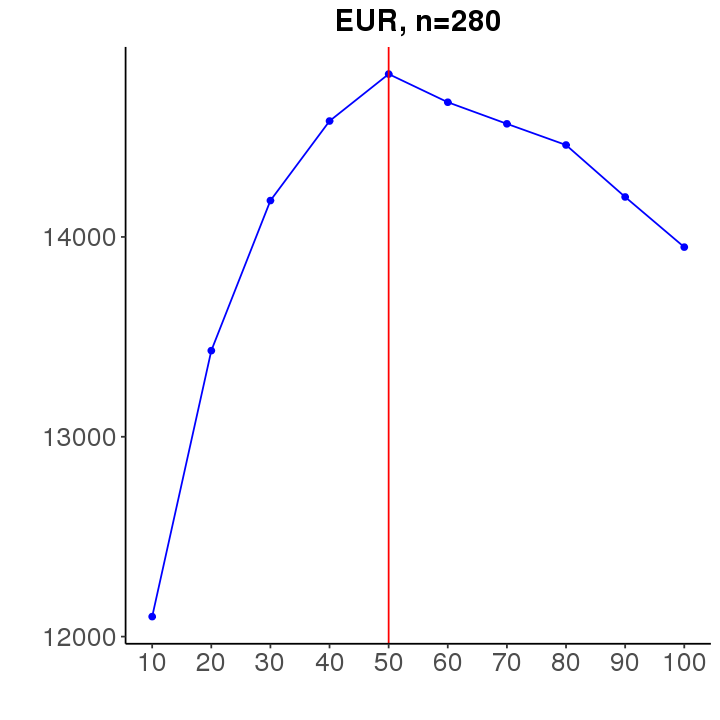

In [6]:
df2 <- data.frame("HCP" = seq(10, 100, 10),
                 "Count" = NA)
for (i in seq(10, 100, 10)) {
    df2[i/10, "Count"] <- read.table(paste0("results/eur_nominal_", i, 
                                           "HCP/significant_feature_count.txt"))[,1]
}

p2 <- ggplot(df2) + 
    geom_point(aes(x=HCP, y=Count), color = "blue") +
    geom_line(aes(x=HCP, y=Count), color = "blue") +
    scale_x_continuous(breaks = seq(0,110,by = 10)) +
    geom_vline(xintercept = 50, color = "red") +
    labs(title = "EUR, n=280", x = "", y = "") +
    theme_classic() +
    theme(axis.text = element_text(size=16),
          axis.title = element_text(size=18),
          plot.title = element_text(size=18, face="bold", hjust = 0.5))
p2

In [59]:
# ggsave("figures/eur_nominal.png", p2, width = 6, height = 6)

#### AMR

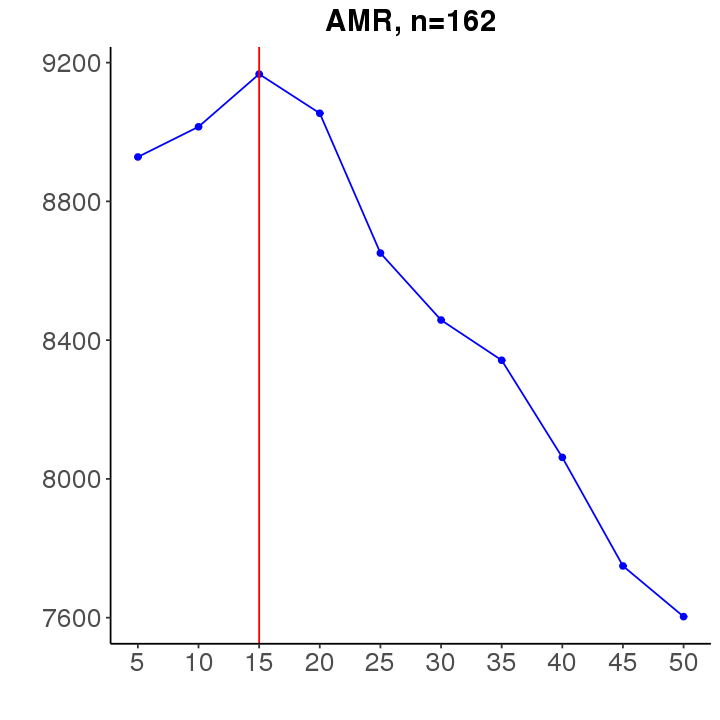

In [7]:
df3 <- data.frame("HCP" = seq(5, 50, 5),
                 "Count" = NA)
for (i in seq(5, 50, 5)) {
    df3[i/5, "Count"] <- read.table(paste0("results/amr_nominal_", i, 
                                           "HCP/significant_feature_count.txt"))[,1]
}

p3 <- ggplot(df3) + 
    geom_point(aes(x=HCP, y=Count), color = "blue") +
    geom_line(aes(x=HCP, y=Count), color = "blue") +
    scale_x_continuous(breaks = seq(0,55,by = 5)) +
    geom_vline(xintercept = 15, color = "red") +
    labs(title = "AMR, n=162", x = "", y = "") +
    theme_classic() +
    theme(axis.text = element_text(size=16),
          axis.title = element_text(size=18),
          plot.title = element_text(size=18, face="bold", hjust = 0.5))
p3

In [8]:
# ggsave("figures/amr_nominal.png", p3, width = 6, height = 6)

#### AFR

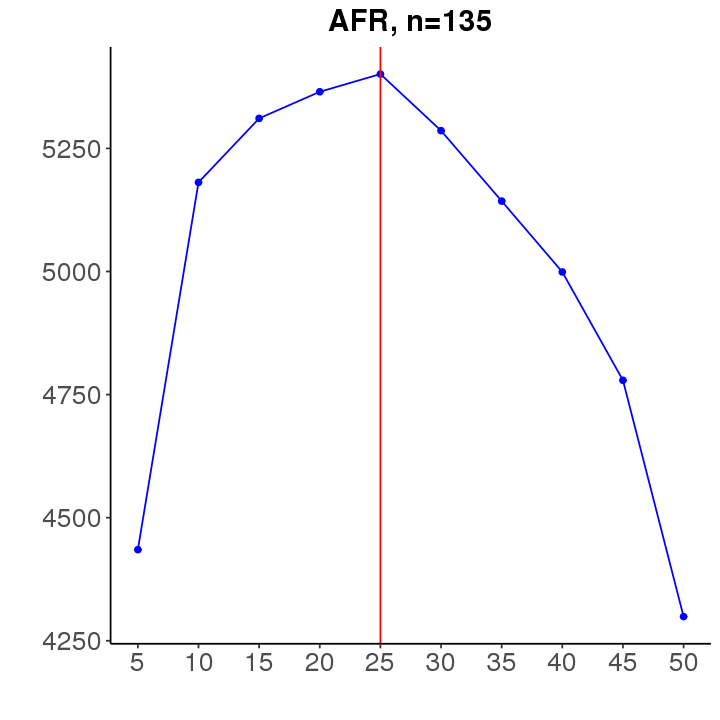

In [9]:
df4 <- data.frame("HCP" = seq(5, 50, 5),
                 "Count" = NA)
for (i in seq(5, 50, 5)) {
    df4[i/5, "Count"] <- read.table(paste0("results/afr_nominal_", i, 
                                           "HCP/significant_feature_count.txt"))[,1]
}

p4 <- ggplot(df4) + 
    geom_point(aes(x=HCP, y=Count), color = "blue") +
    geom_line(aes(x=HCP, y=Count), color = "blue") +
    scale_x_continuous(breaks = seq(0,55,by = 5)) +
    geom_vline(xintercept = 25, color = "red") +
    labs(title = "AFR, n=135", x = "", y = "") +
    theme_classic() +
    theme(axis.text = element_text(size=16),
          axis.title = element_text(size=18),
          plot.title = element_text(size=18, face="bold", hjust = 0.5))
p4

In [10]:
# ggsave("figures/afr_nominal.png", p4, width = 6, height = 6)

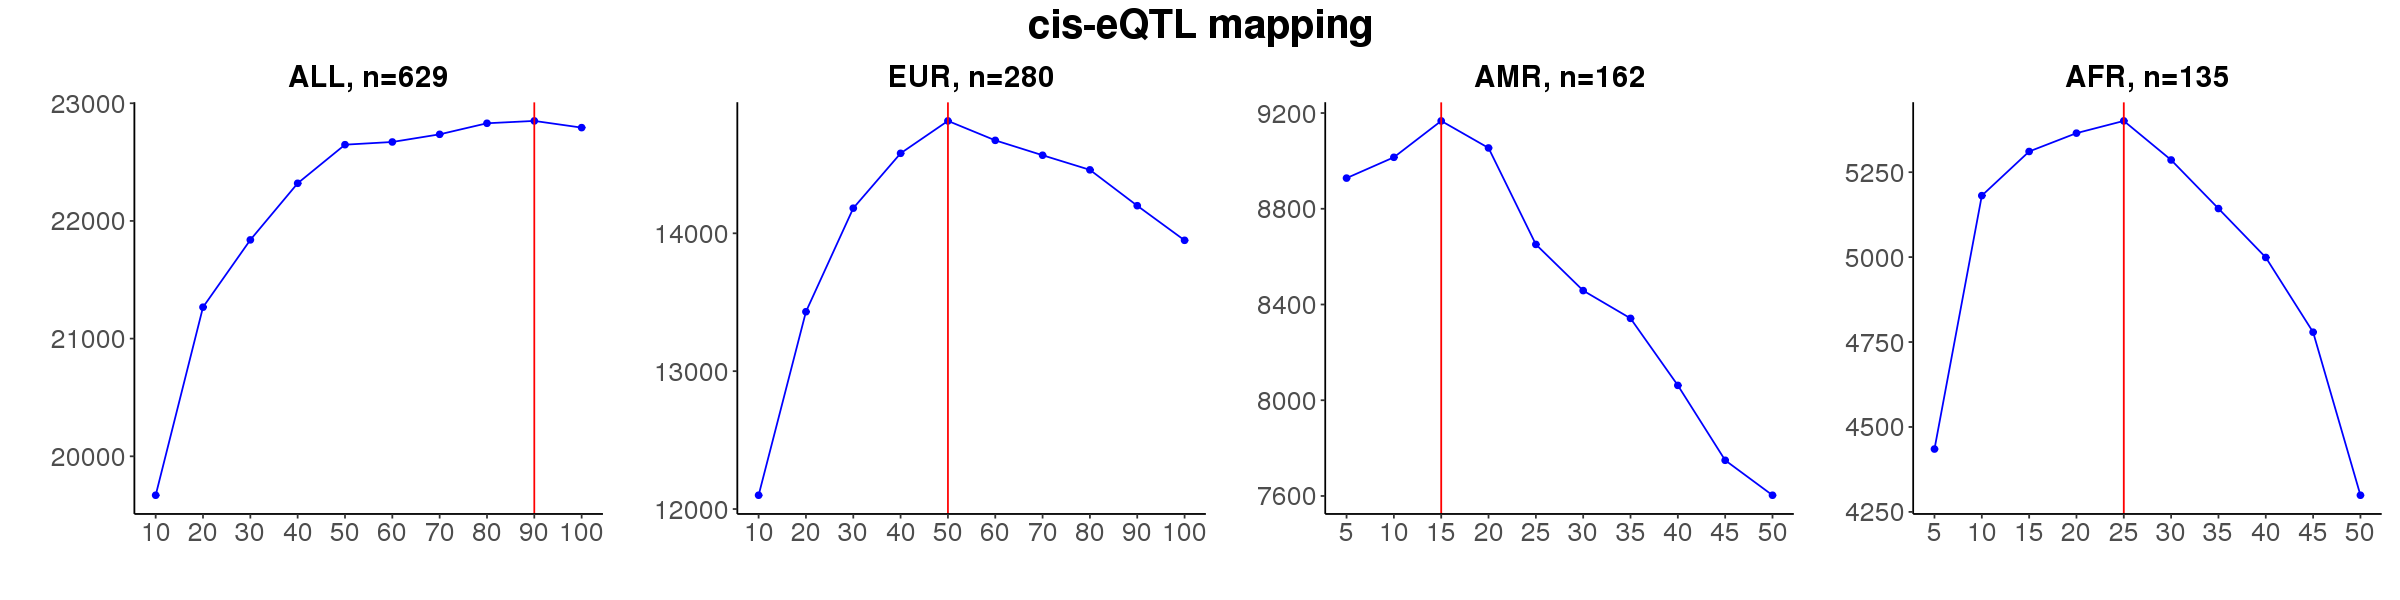

In [11]:
options(repr.plot.width=20, repr.plot.height=5)

p <- p1 + p2 + p3 + p4 +  
  plot_annotation(title = "cis-eQTL mapping",
                 theme = theme(plot.title = element_text(size = 24, face="bold", hjust = 0.5))) +
  plot_layout(ncol = 4)

p

In [12]:
ggsave("figures/nominal.png", p, height = 5, width = 20)

### 5: Gene expression regression, check batch effects

#### Mixed ancestry

In [3]:
datExpr <- fread("data/gene.counts.processed.tsv", data.table=F)
rownames(datExpr) <- datExpr$V1
datExpr <- datExpr[,-1]

Warning message in fread("data/gene.counts.processed.tsv", data.table = F):
“Detected 642 column names but the data has 643 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”


In [4]:
datExpr_noCombat <- fread("data/gene.counts.processed.noComBat.tsv", data.table=F)
rownames(datExpr_noCombat) <- datExpr_noCombat$V1
datExpr_noCombat <- datExpr_noCombat[,-1]

Warning message in fread("data/gene.counts.processed.noComBat.tsv", data.table = F):
“Detected 642 column names but the data has 643 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”


In [5]:
cov <- read.table("data/90hcp_cov.txt", header = T, stringsAsFactors = F, check.names = F)
rownames(cov) <- cov$id
cov <- cov[,-1]

In [6]:
# remove related
rel <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/related.txt", header = F, stringsAsFactors = F)[,1]
rel

[1] "1614"   "11602"  "Br1779" "Br2394" "Br2402" "Br2411" "Br2412" "1713"  
 [9] "11841"  "Br1794" "HSB148" "HSB107" "HSB154" "HSB100"

In [7]:
cov <- cov[,!names(cov) %in% rel]
dim(cov)

[1]  97 629

In [8]:
datExpr <- datExpr[,!names(datExpr) %in% rel]
dim(datExpr)
datExpr_noCombat <- datExpr_noCombat[,!names(datExpr_noCombat) %in% rel]
dim(datExpr_noCombat)

[1] 31947   629

[1] 31947   629

In [9]:
cov[cov=="F"] <- 0
cov[cov=="M"] <- 1

In [10]:
cov <- t(cov)
cov <- cbind(1, cov)
storage.mode(cov) <- "numeric"

Y <- as.matrix(datExpr)
X <- as.matrix(cov)

beta <- (solve(t(X)%*%X)%*%t(X))%*%t(Y)
datExpr_regressed <- Y - t(X[,-1]  %*% beta[-1,])

In [11]:
walker <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_walker.txt")
obrien <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_obrien.txt")
werling <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_werling.txt")
hdbr <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_hdbr.txt")
libd <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_libd.txt")

groups <- c()

for (i in 1:ncol(datExpr_regressed)) {
  sample <- colnames(datExpr_regressed)[i]
  if (sample %in% walker[,1]) {
    groups[i] <- "Walker"
  }
  if (sample %in% obrien[,1]) {
    groups[i] <- "Obrien"
  }
  if (sample %in% werling[,1]) {
    groups[i] <- "Werling"
  }
  if (sample %in% hdbr[,1]) {
    groups[i] <- "HDBR"
  }
  if (sample %in% libd[,1]) {
    groups[i] <- "LIBD"
  }
}

groups_fac <- factor(groups)

In [12]:
# center the data; use SVD to calculate PCs
s <- svd(datExpr_regressed - rowMeans(datExpr_regressed))
PC1 <- s$d[1]*s$v[,1]
PC2 <- s$d[2]*s$v[,2]
data <- data.frame(PC1, PC2, "Data" = groups_fac)

In [13]:
# combat only
s_1 <- svd(datExpr - rowMeans(datExpr))
PC1_1 <- s_1$d[1]*s_1$v[,1]
PC2_1 <- s_1$d[2]*s_1$v[,2]
data1 <- data.frame(PC1_1, PC2_1, "Data" = groups_fac)

In [14]:
# unregressed
s_2 <- svd(datExpr_noCombat - rowMeans(datExpr_noCombat))
PC1_2 <- s_2$d[1]*s_2$v[,1]
PC2_2 <- s_2$d[2]*s_2$v[,2]
data2 <- data.frame(PC1_2, PC2_2, "Data" = groups_fac)

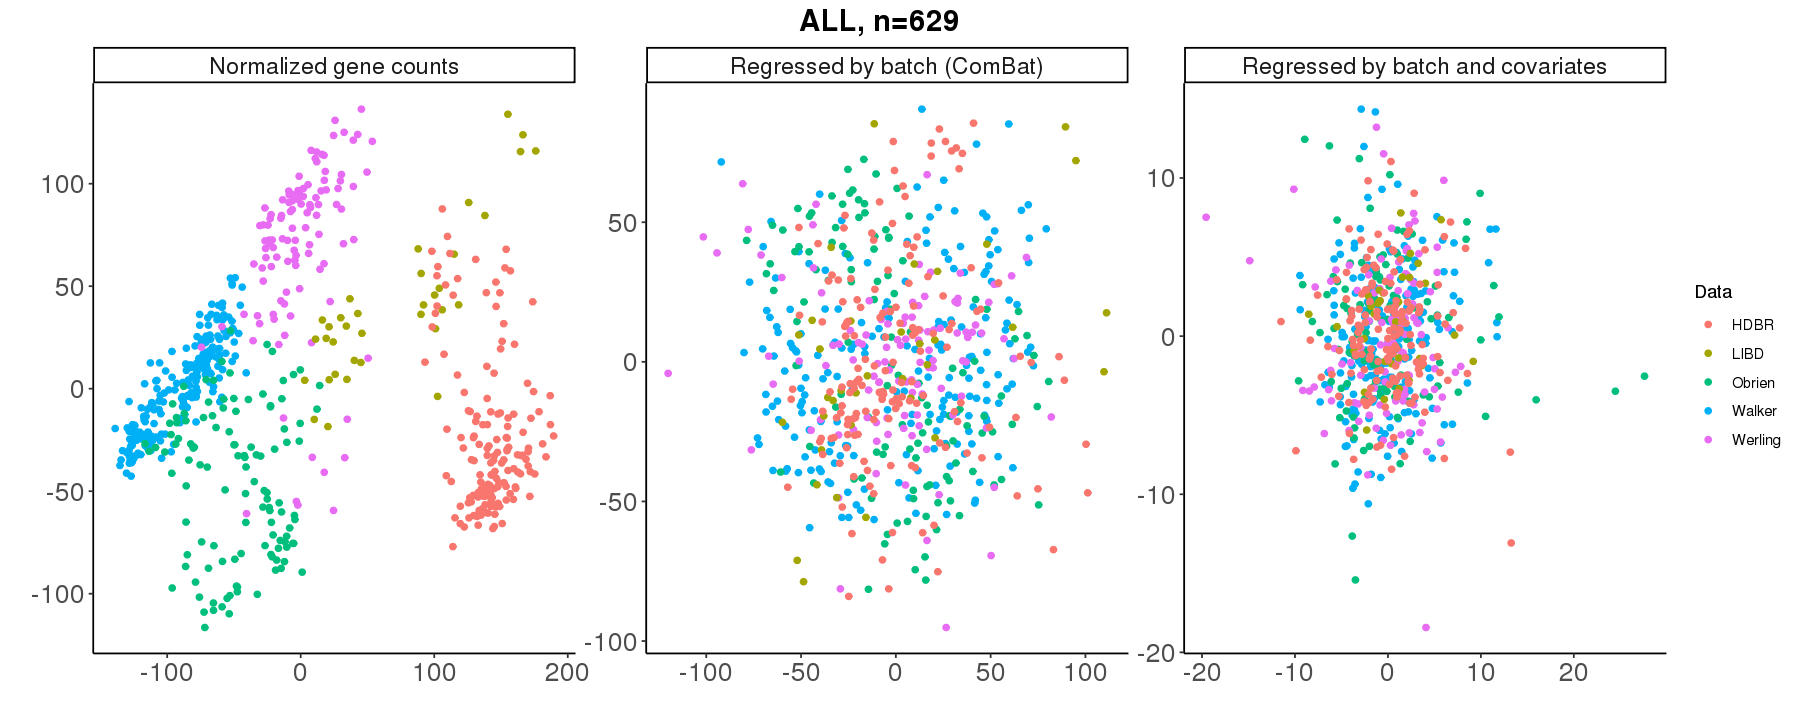

In [15]:
options(repr.plot.width=15, repr.plot.height=6)

colnames(data1) <- colnames(data2) <- c("PC1", "PC2", "Data")
data3 <- rbind(data, data1, data2)

data3$group <- c(rep("Regressed by batch and covariates", dim(data)[1]), 
                 rep("Regressed by batch (ComBat)", dim(data1)[1]),
                 rep("Normalized gene counts", dim(data2)[1]))
p1 <- ggplot(data3, aes(x=PC1, y=PC2, color=Data)) +
  geom_point() +
  facet_wrap(~group, scales = "free") +
  labs(title = "ALL, n=629", x = "", y = "") +
  theme_classic() +
  theme(axis.text = element_text(size=16),
        plot.title = element_text(size=18, face="bold", hjust = 0.5),
        strip.text.x = element_text(size=14))
p1

In [20]:
# ggsave("figures/mixed_regress.png", p2, width = 15, height = 6)

#### EUR

Warning message in fread("data/eur/gene.counts.processed.tsv", data.table = F):
“Detected 284 column names but the data has 285 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”
Warning message in fread("data/eur/gene.counts.processed.noComBat.tsv", data.table = F):
“Detected 284 column names but the data has 285 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”


[1]  57 280

[1] 31947   280

[1] 31947   280

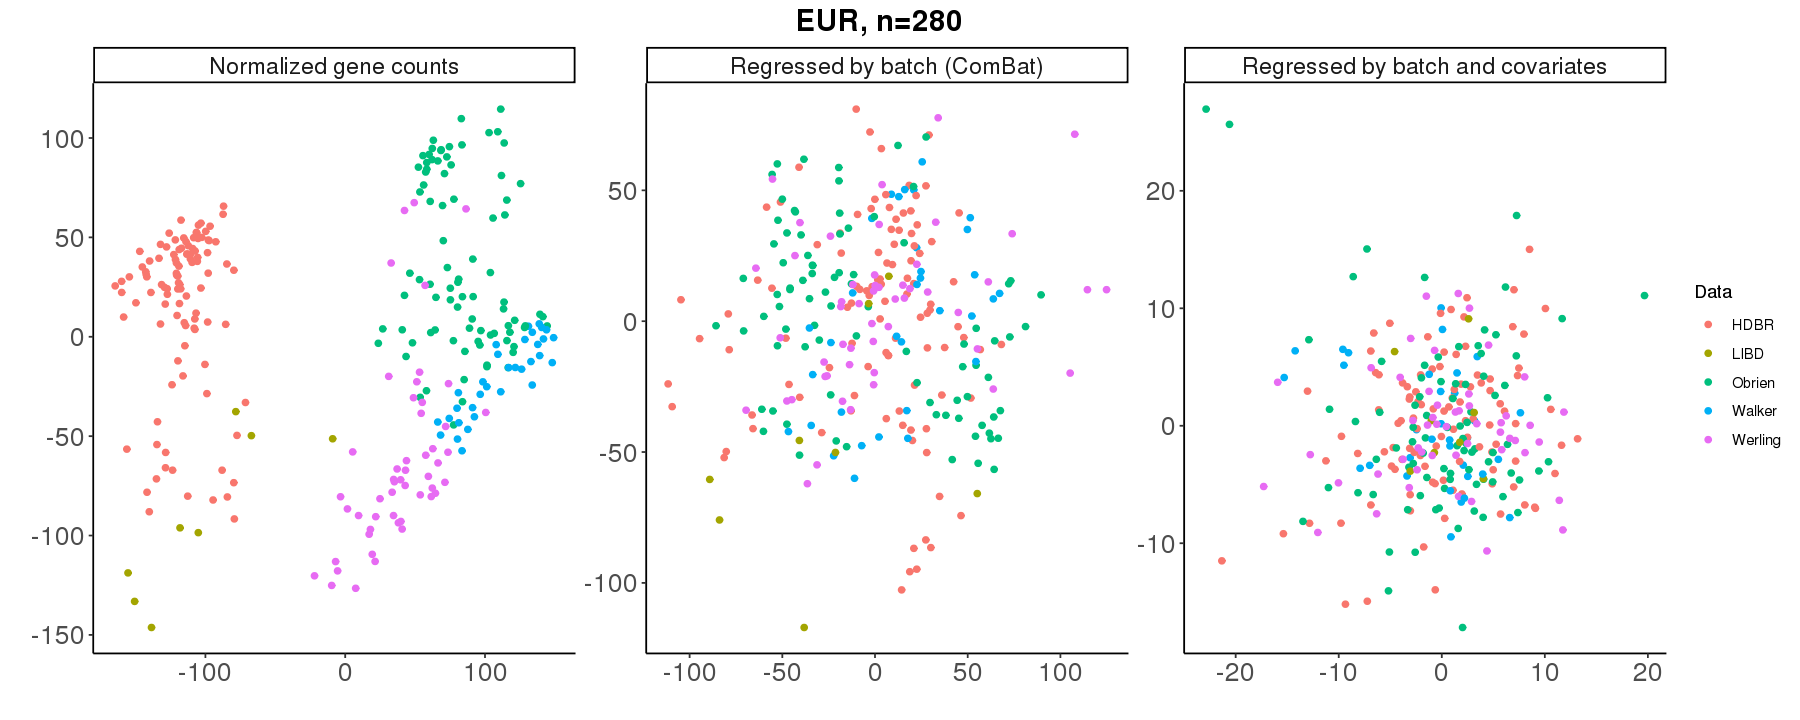

In [16]:
datExpr <- fread("data/eur/gene.counts.processed.tsv", data.table=F)
rownames(datExpr) <- datExpr$V1
datExpr <- datExpr[,-1]

datExpr_noCombat <- fread("data/eur/gene.counts.processed.noComBat.tsv", data.table=F)
rownames(datExpr_noCombat) <- datExpr_noCombat$V1
datExpr_noCombat <- datExpr_noCombat[,-1]

cov <- read.table("data/eur/50HCP_cov.txt", header = T, stringsAsFactors = F, check.names = F)
rownames(cov) <- cov$id
cov <- cov[,-1]

# remove rel
cov <- cov[,!names(cov) %in% rel]
dim(cov)
datExpr <- datExpr[,!names(datExpr) %in% rel]
dim(datExpr)
datExpr_noCombat <- datExpr_noCombat[,!names(datExpr_noCombat) %in% rel]
dim(datExpr_noCombat)

cov[cov=="F"] <- 0
cov[cov=="M"] <- 1

cov <- t(cov)
cov <- cbind(1, cov)
storage.mode(cov) <- "numeric"

Y <- as.matrix(datExpr)
X <- as.matrix(cov)

beta <- (solve(t(X)%*%X)%*%t(X))%*%t(Y)
datExpr_regressed <- Y - t(X[,-1]  %*% beta[-1,])

walker <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_walker.txt")
obrien <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_obrien.txt")
werling <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_werling.txt")
hdbr <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_hdbr.txt")
libd <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_libd.txt")

groups <- c()

for (i in 1:ncol(datExpr_regressed)) {
  sample <- colnames(datExpr_regressed)[i]
  if (sample %in% walker[,1]) {
    groups[i] <- "Walker"
  }
  if (sample %in% obrien[,1]) {
    groups[i] <- "Obrien"
  }
  if (sample %in% werling[,1]) {
    groups[i] <- "Werling"
  }
  if (sample %in% hdbr[,1]) {
    groups[i] <- "HDBR"
  }
  if (sample %in% libd[,1]) {
    groups[i] <- "LIBD"
  }
}

groups_fac <- factor(groups)

# center the data; use SVD to calculate PCs
s <- svd(datExpr_regressed - rowMeans(datExpr_regressed))
PC1 <- s$d[1]*s$v[,1]
PC2 <- s$d[2]*s$v[,2]
data <- data.frame(PC1, PC2, "Data" = groups_fac)

# combat only
s_1 <- svd(datExpr - rowMeans(datExpr))
PC1_1 <- s_1$d[1]*s_1$v[,1]
PC2_1 <- s_1$d[2]*s_1$v[,2]
data1 <- data.frame(PC1_1, PC2_1, "Data" = groups_fac)

# unregressed
s_2 <- svd(datExpr_noCombat - rowMeans(datExpr_noCombat))
PC1_2 <- s_2$d[1]*s_2$v[,1]
PC2_2 <- s_2$d[2]*s_2$v[,2]
data2 <- data.frame(PC1_2, PC2_2, "Data" = groups_fac)

options(repr.plot.width=15, repr.plot.height=6)

colnames(data1) <- colnames(data2) <- c("PC1", "PC2", "Data")
data3 <- rbind(data, data1, data2)

data3$group <- c(rep("Regressed by batch and covariates", dim(data)[1]), 
                 rep("Regressed by batch (ComBat)", dim(data1)[1]),
                 rep("Normalized gene counts", dim(data2)[1]))
p2 <- ggplot(data3, aes(x=PC1, y=PC2, color=Data)) +
  geom_point() +
  facet_wrap(~group, scales = "free") +
  labs(x = "", y = "", 
       title = "EUR, n=280") +
  theme_classic() +
  theme(axis.text = element_text(size=16),
        plot.title = element_text(size=18, face="bold", hjust = 0.5),
        strip.text.x = element_text(size=14))
p2

In [11]:
# ggsave("figures/eur_regress.png", p6, width = 15, height = 6)

#### AMR

Warning message in fread("data/amr/gene.counts.processed.tsv", data.table = F):
“Detected 164 column names but the data has 165 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”
Warning message in fread("data/amr/gene.counts.processed.noComBat.tsv", data.table = F):
“Detected 164 column names but the data has 165 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”


[1]  22 162

[1] 31947   162

[1] 31947   162

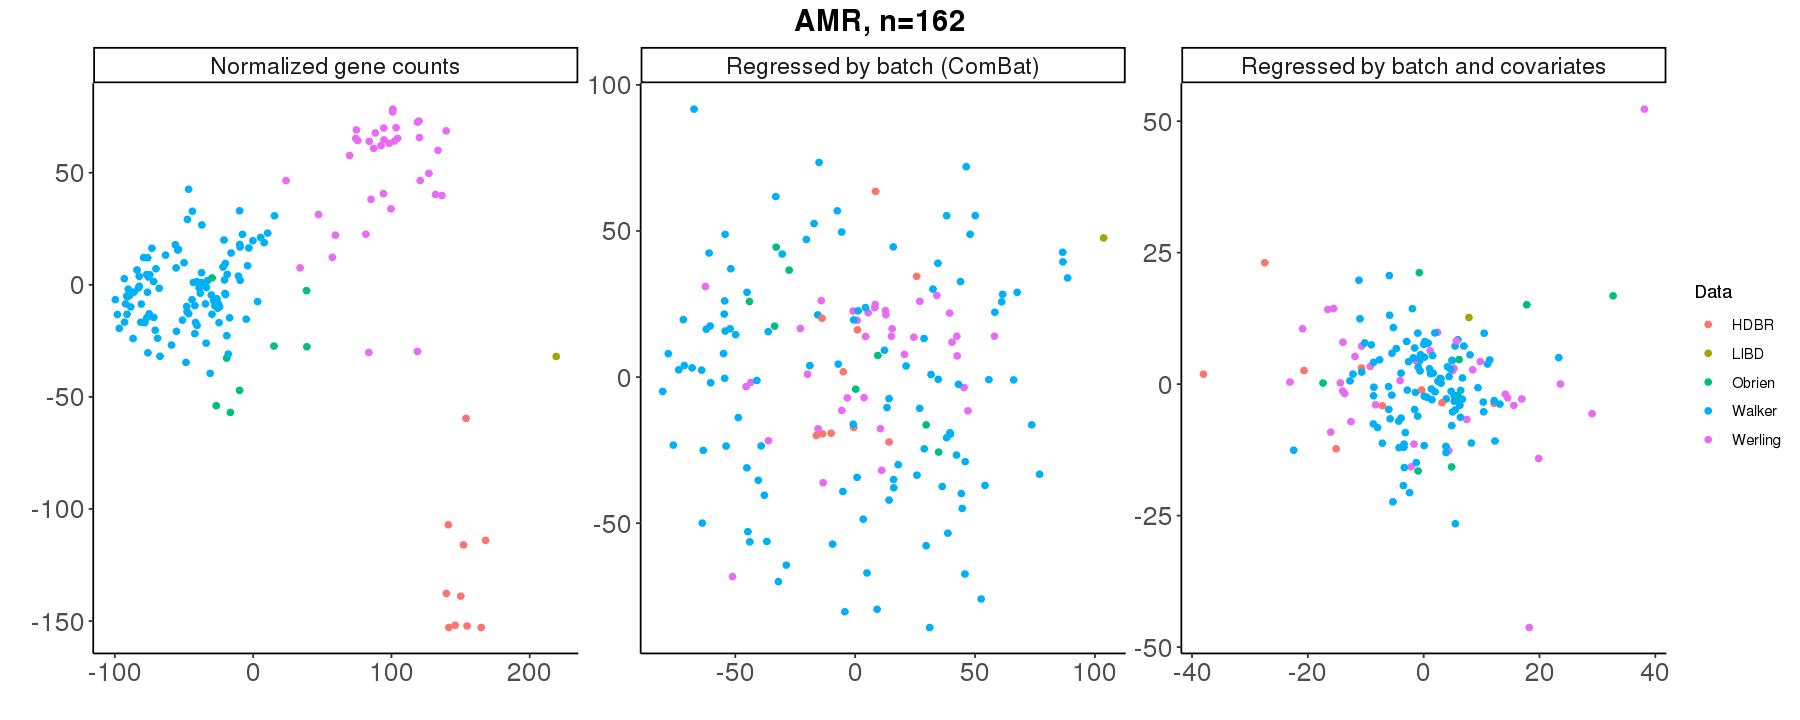

In [17]:
datExpr <- fread("data/amr/gene.counts.processed.tsv", data.table=F)
rownames(datExpr) <- datExpr$V1
datExpr <- datExpr[,-1]

datExpr_noCombat <- fread("data/amr/gene.counts.processed.noComBat.tsv", data.table=F)
rownames(datExpr_noCombat) <- datExpr_noCombat$V1
datExpr_noCombat <- datExpr_noCombat[,-1]

cov <- read.table("data/amr/15HCP_cov.txt", header = T, stringsAsFactors = F, check.names = F)
rownames(cov) <- cov$id
cov <- cov[,-1]

# remove rel
cov <- cov[,!names(cov) %in% rel]
dim(cov)
datExpr <- datExpr[,!names(datExpr) %in% rel]
dim(datExpr)
datExpr_noCombat <- datExpr_noCombat[,!names(datExpr_noCombat) %in% rel]
dim(datExpr_noCombat)

cov[cov=="F"] <- 0
cov[cov=="M"] <- 1

cov <- t(cov)
cov <- cbind(1, cov)
storage.mode(cov) <- "numeric"

Y <- as.matrix(datExpr)
X <- as.matrix(cov)

beta <- (solve(t(X)%*%X)%*%t(X))%*%t(Y)
datExpr_regressed <- Y - t(X[,-1]  %*% beta[-1,])

# walker <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_walker.txt")
# obrien <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_obrien.txt")
# werling <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_werling.txt")
# hdbr <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_hdbr.txt")
# libd <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_libd.txt")

groups <- c()

for (i in 1:ncol(datExpr_regressed)) {
  sample <- colnames(datExpr_regressed)[i]
  if (sample %in% walker[,1]) {
    groups[i] <- "Walker"
  }
  if (sample %in% obrien[,1]) {
    groups[i] <- "Obrien"
  }
  if (sample %in% werling[,1]) {
    groups[i] <- "Werling"
  }
  if (sample %in% hdbr[,1]) {
    groups[i] <- "HDBR"
  }
  if (sample %in% libd[,1]) {
    groups[i] <- "LIBD"
  }
}

groups_fac <- factor(groups)

# center the data; use SVD to calculate PCs
s <- svd(datExpr_regressed - rowMeans(datExpr_regressed))
PC1 <- s$d[1]*s$v[,1]
PC2 <- s$d[2]*s$v[,2]
data <- data.frame(PC1, PC2, "Data" = groups_fac)

# combat only
s_1 <- svd(datExpr - rowMeans(datExpr))
PC1_1 <- s_1$d[1]*s_1$v[,1]
PC2_1 <- s_1$d[2]*s_1$v[,2]
data1 <- data.frame(PC1_1, PC2_1, "Data" = groups_fac)

# unregressed
s_2 <- svd(datExpr_noCombat - rowMeans(datExpr_noCombat))
PC1_2 <- s_2$d[1]*s_2$v[,1]
PC2_2 <- s_2$d[2]*s_2$v[,2]
data2 <- data.frame(PC1_2, PC2_2, "Data" = groups_fac)

options(repr.plot.width=15, repr.plot.height=6)

colnames(data1) <- colnames(data2) <- c("PC1", "PC2", "Data")
data3 <- rbind(data, data1, data2)

data3$group <- c(rep("Regressed by batch and covariates", dim(data)[1]), 
                 rep("Regressed by batch (ComBat)", dim(data1)[1]),
                 rep("Normalized gene counts", dim(data2)[1]))
p3 <- ggplot(data3, aes(x=PC1, y=PC2, color=Data)) +
  geom_point() +
  facet_wrap(~group, scales = "free") +
  labs(x = "", y = "", 
       title = "AMR, n=162") +
  theme_classic() +
  theme(axis.text = element_text(size=16),
        plot.title = element_text(size=18, face="bold", hjust = 0.5),
        strip.text.x = element_text(size=14))
p3

#### AFR

Warning message in fread("data/afr/gene.counts.processed.tsv", data.table = F):
“Detected 142 column names but the data has 143 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”
Warning message in fread("data/afr/gene.counts.processed.noComBat.tsv", data.table = F):
“Detected 142 column names but the data has 143 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”


[1]  32 135

[1] 31947   135

[1] 31947   135

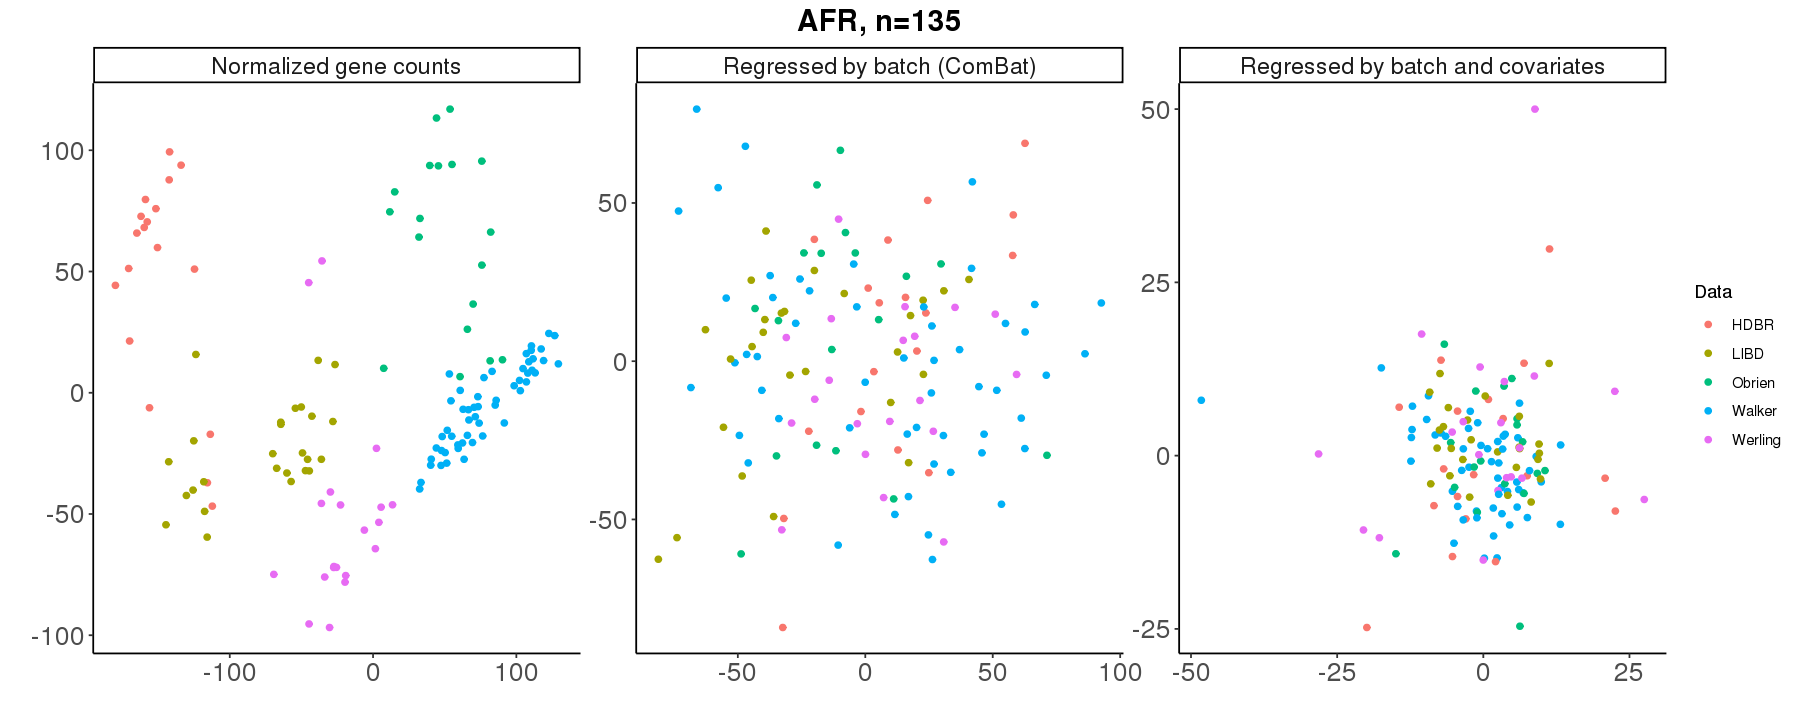

In [18]:
datExpr <- fread("data/afr/gene.counts.processed.tsv", data.table=F)
rownames(datExpr) <- datExpr$V1
datExpr <- datExpr[,-1]

datExpr_noCombat <- fread("data/afr/gene.counts.processed.noComBat.tsv", data.table=F)
rownames(datExpr_noCombat) <- datExpr_noCombat$V1
datExpr_noCombat <- datExpr_noCombat[,-1]

cov <- read.table("data/afr/25HCP_cov.txt", header = T, stringsAsFactors = F, check.names = F)
rownames(cov) <- cov$id
cov <- cov[,-1]

# remove rel
cov <- cov[,!names(cov) %in% rel]
dim(cov)
datExpr <- datExpr[,!names(datExpr) %in% rel]
dim(datExpr)
datExpr_noCombat <- datExpr_noCombat[,!names(datExpr_noCombat) %in% rel]
dim(datExpr_noCombat)

cov[cov=="F"] <- 0
cov[cov=="M"] <- 1

cov <- t(cov)
cov <- cbind(1, cov)
storage.mode(cov) <- "numeric"

Y <- as.matrix(datExpr)
X <- as.matrix(cov)

beta <- (solve(t(X)%*%X)%*%t(X))%*%t(Y)
datExpr_regressed <- Y - t(X[,-1]  %*% beta[-1,])

# walker <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_walker.txt")
# obrien <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_obrien.txt")
# werling <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_werling.txt")
# hdbr <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_hdbr.txt")
# libd <- read.table("~/project-gandalm/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/geno_subj/geno_subj_libd.txt")

groups <- c()

for (i in 1:ncol(datExpr_regressed)) {
  sample <- colnames(datExpr_regressed)[i]
  if (sample %in% walker[,1]) {
    groups[i] <- "Walker"
  }
  if (sample %in% obrien[,1]) {
    groups[i] <- "Obrien"
  }
  if (sample %in% werling[,1]) {
    groups[i] <- "Werling"
  }
  if (sample %in% hdbr[,1]) {
    groups[i] <- "HDBR"
  }
  if (sample %in% libd[,1]) {
    groups[i] <- "LIBD"
  }
}

groups_fac <- factor(groups)

# center the data; use SVD to calculate PCs
s <- svd(datExpr_regressed - rowMeans(datExpr_regressed))
PC1 <- s$d[1]*s$v[,1]
PC2 <- s$d[2]*s$v[,2]
data <- data.frame(PC1, PC2, "Data" = groups_fac)

# combat only
s_1 <- svd(datExpr - rowMeans(datExpr))
PC1_1 <- s_1$d[1]*s_1$v[,1]
PC2_1 <- s_1$d[2]*s_1$v[,2]
data1 <- data.frame(PC1_1, PC2_1, "Data" = groups_fac)

# unregressed
s_2 <- svd(datExpr_noCombat - rowMeans(datExpr_noCombat))
PC1_2 <- s_2$d[1]*s_2$v[,1]
PC2_2 <- s_2$d[2]*s_2$v[,2]
data2 <- data.frame(PC1_2, PC2_2, "Data" = groups_fac)

options(repr.plot.width=15, repr.plot.height=6)

colnames(data1) <- colnames(data2) <- c("PC1", "PC2", "Data")
data3 <- rbind(data, data1, data2)

data3$group <- c(rep("Regressed by batch and covariates", dim(data)[1]), 
                 rep("Regressed by batch (ComBat)", dim(data1)[1]),
                 rep("Normalized gene counts", dim(data2)[1]))
p4 <- ggplot(data3, aes(x=PC1, y=PC2, color=Data)) +
  geom_point() +
  facet_wrap(~group, scales = "free") +
  labs(x = "", y = "", 
       title = "AFR, n=135") +
  theme_classic() +
  theme(axis.text = element_text(size=16),
        plot.title = element_text(size=18, face="bold", hjust = 0.5),
        strip.text.x = element_text(size=14))
p4

In [19]:
options(repr.plot.width=15, repr.plot.height=24)

p <- p1 / p2 / p3 / p4 +
  plot_annotation(title = "PCA of gene expression",
                 theme = theme(plot.title = element_text(size = 24, face="bold", hjust = 0.5))) 
#   plot_annotation(tag_level = 'A') &
#                  theme(plot.tag = element_text(size = 18, face = "bold"))

# p

In [20]:
ggsave("figures/regress.png", p, width = 15, height = 24)

### 6: Check beta-approximated permutation pval

In [13]:
mixed <- fread("results/mixed_perm_90hcp/all.chunks.txt.gz", data.table=F)
colnames(mixed) <- c("pid", "nvar", "shape1", "shape2", "dummy", "sid", "dist", "npval", "slope", "ppval", "bpval")

In [14]:
mixed <- mixed[complete.cases(mixed),]
mixed <- arrange(mixed, npval, desc(bpval)) %>% group_by(pid) %>% dplyr::slice(1) %>% ungroup() %>% as.data.frame()

In [15]:
round(cor(mixed[, 'ppval'], mixed[, 'bpval']), 4)

[1] 0.9999

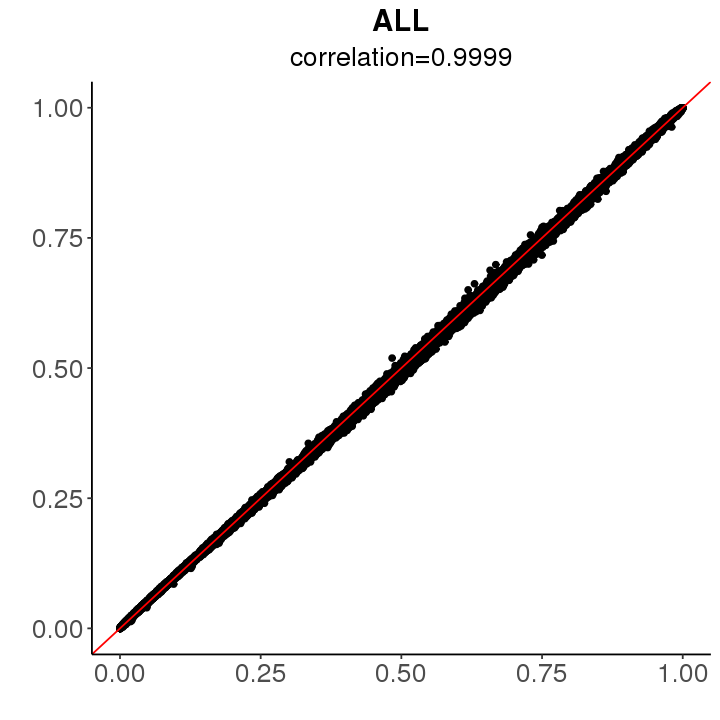

In [16]:
options(repr.plot.width=6, repr.plot.height=6)
p1 <- ggplot(mixed, aes(x = ppval, y = bpval)) +
    geom_point() +
    geom_abline(intercept = 0, slope = 1, color = "red") +
    labs(x = "",
         y = "",
         title = "ALL",
         subtitle = "correlation=0.9999") +
    theme_classic() +
    theme(axis.text = element_text(size=16),
        plot.title = element_text(size=18, face="bold", hjust = 0.5),
          plot.subtitle = element_text(size=16, hjust = 0.5))
p1

In [17]:
# ggsave("figures/mixed_check.png", p, width = 6, height = 6)

[1] 0.9998

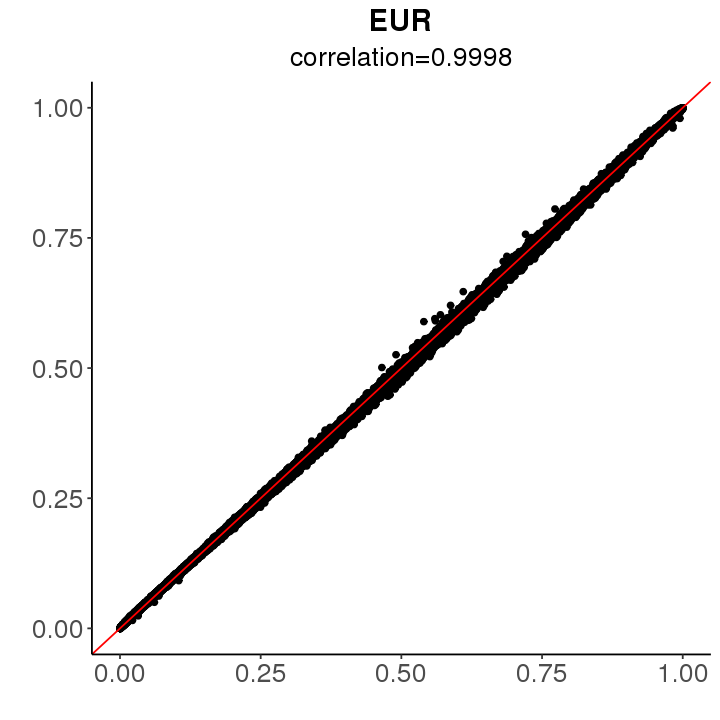

In [18]:
eur <- fread("results/eur_perm_50HCP/all.chunks.txt.gz", data.table=F)
colnames(eur) <- c("pid", "nvar", "shape1", "shape2", "dummy", "sid", "dist", "npval", "slope", "ppval", "bpval")
eur <- eur[complete.cases(eur),]
eur <- arrange(eur, npval, desc(bpval)) %>% group_by(pid) %>% dplyr::slice(1) %>% ungroup() %>% as.data.frame()
round(cor(eur[, 'ppval'], eur[, 'bpval']), 4)

p2 <- ggplot(eur, aes(x = ppval, y = bpval)) +
    geom_point() +
    geom_abline(intercept = 0, slope = 1, color = "red") +
    labs(x = "",
         y = "",
         title = "EUR",
         subtitle = "correlation=0.9998") +
    theme_classic() +
    theme(axis.text = element_text(size=16),
        plot.title = element_text(size=18, face="bold", hjust = 0.5),
          plot.subtitle = element_text(size=16, hjust = 0.5))
p2
# ggsave("figures/eur_check.png", p1, width = 6, height = 6)

[1] 0.9998

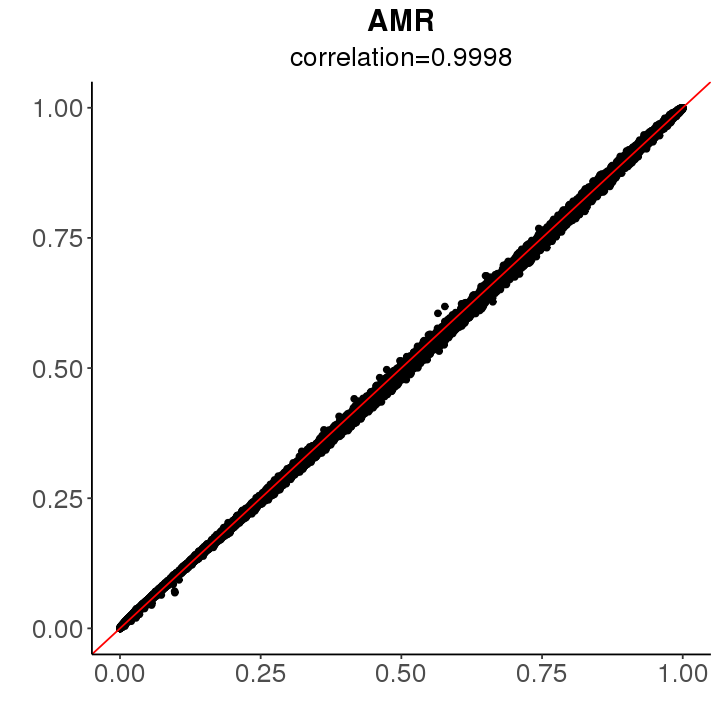

In [19]:
amr <- fread("results/amr_perm_15HCP/all.chunks.txt.gz", data.table=F)
colnames(amr) <- c("pid", "nvar", "shape1", "shape2", "dummy", "sid", "dist", "npval", "slope", "ppval", "bpval")
amr <- amr[complete.cases(amr),]
amr <- arrange(amr, npval, desc(bpval)) %>% group_by(pid) %>% dplyr::slice(1) %>% ungroup() %>% as.data.frame()
round(cor(amr[, 'ppval'], amr[, 'bpval']), 4)
p3 <- ggplot(amr, aes(x = ppval, y = bpval)) +
    geom_point() +
    geom_abline(intercept = 0, slope = 1, color = "red") +
    labs(x = "",
         y = "",
         title = "AMR",
         subtitle = "correlation=0.9998") +
    theme_classic() +
    theme(axis.text = element_text(size=16),
        plot.title = element_text(size=18, face="bold", hjust = 0.5),
          plot.subtitle = element_text(size=16, hjust = 0.5))
p3
# ggsave("figures/amr_check.png", p2, width = 6, height = 6)

[1] 0.9998

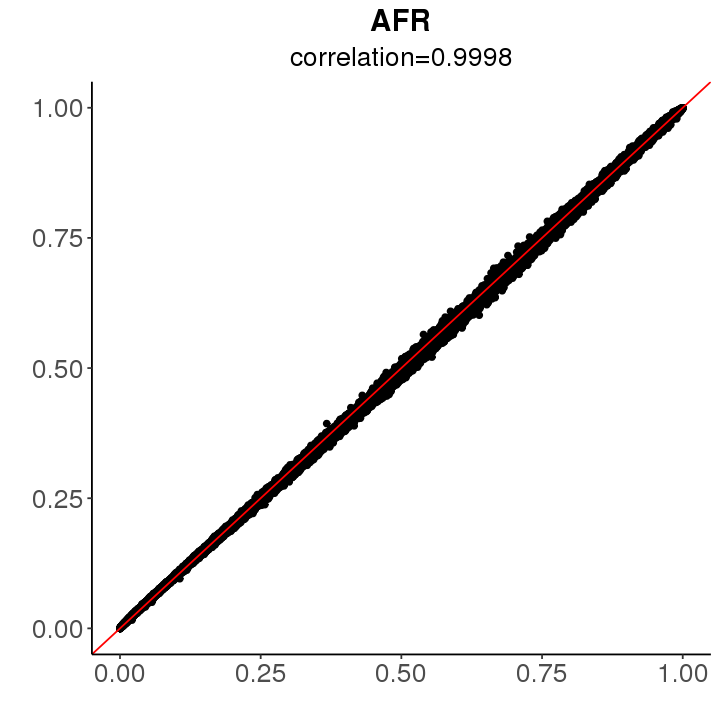

In [20]:
afr <- fread("results/afr_perm_25HCP/all.chunks.txt.gz", data.table=F)
colnames(afr) <- c("pid", "nvar", "shape1", "shape2", "dummy", "sid", "dist", "npval", "slope", "ppval", "bpval")
afr <- afr[complete.cases(afr),]
afr <- arrange(afr, npval, desc(bpval)) %>% group_by(pid) %>% dplyr::slice(1) %>% ungroup() %>% as.data.frame()
round(cor(afr[, 'ppval'], afr[, 'bpval']), 4)

p4 <- ggplot(afr, aes(x = ppval, y = bpval)) +
    geom_point() +
    geom_abline(intercept = 0, slope = 1, color = "red") +
    labs(x = "",
         y = "",
         title = "AFR",
         subtitle = "correlation=0.9998") +
    theme_classic() +
    theme(axis.text = element_text(size=16),
        plot.title = element_text(size=18, face="bold", hjust = 0.5),
          plot.subtitle = element_text(size=16, hjust = 0.5))
p4
# ggsave("figures/afr_check.png", p3, width = 6, height = 6)

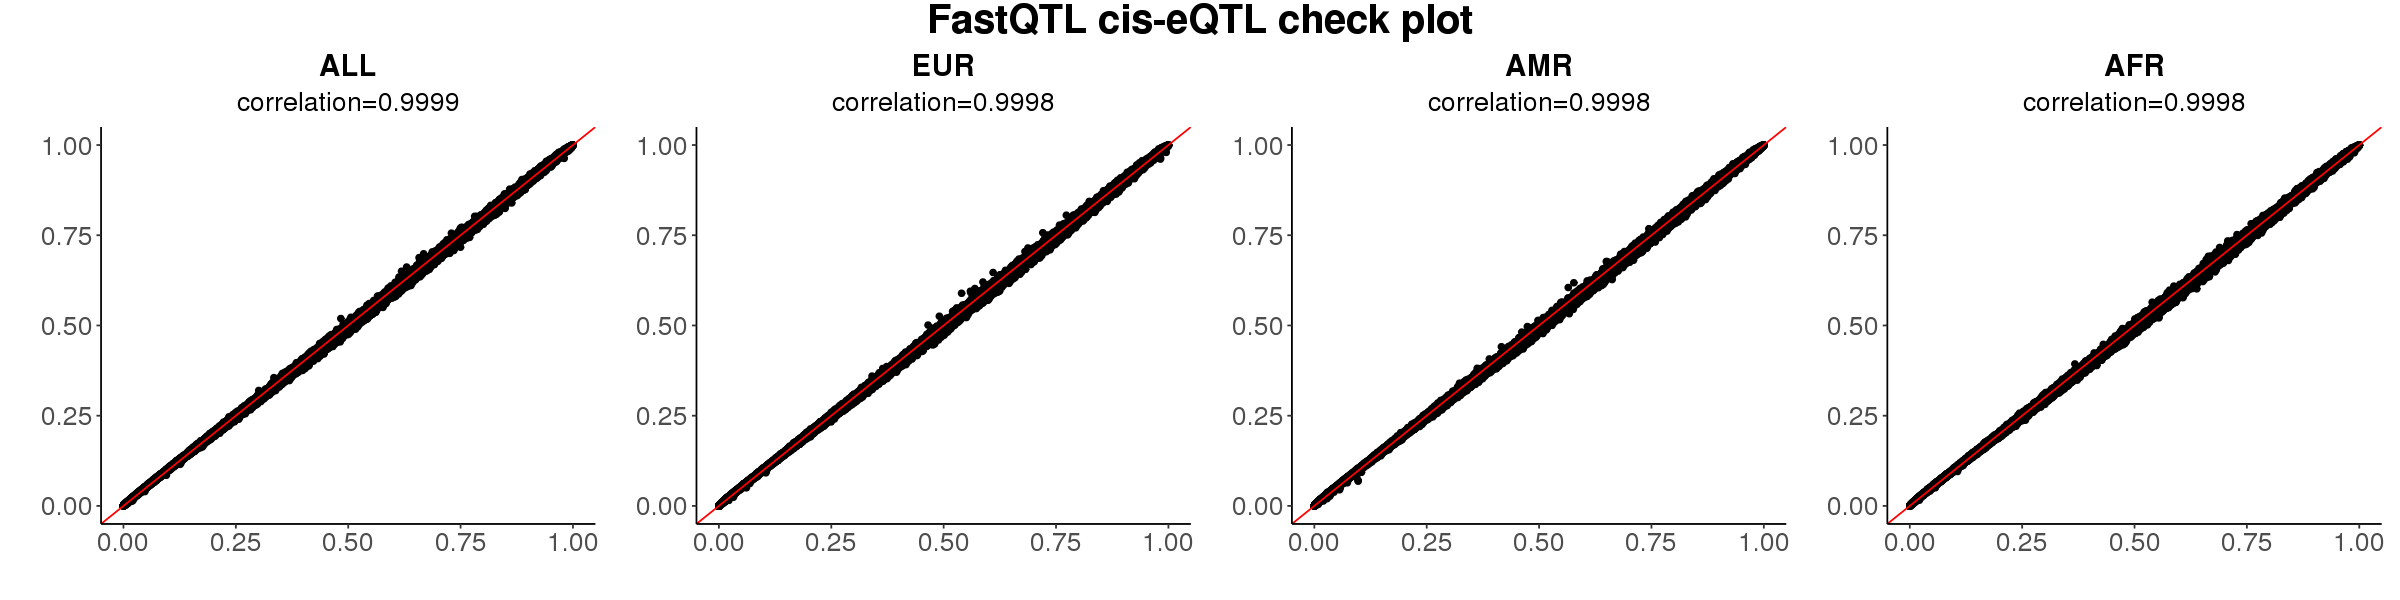

In [23]:
options(repr.plot.width=20, repr.plot.height=5)

p <- p1 + p2 + p3 + p4 +
  plot_annotation(title = "FastQTL cis-eQTL check plot",
                 theme = theme(plot.title = element_text(size = 24, face="bold", hjust = 0.5))) +
  plot_layout(ncol = 4)

p

In [24]:
ggsave("figures/check.png", p, width = 20, height = 5)

### 7: dTSS of top eQTL

In [3]:
mixed_sig <- read.table("results/mixed_perm_90hcp/sig_pheno.txt", header = T, stringsAsFactors = F)
all_assoc <- fread("results/mixed_perm_90hcp/all_assoc.txt.gz", data.table = F)

eur_sig <- read.table("results/eur_perm_50HCP/sig_pheno.txt", header = T, stringsAsFactors = F)
all_assoc_eur <- fread("results/eur_perm_50HCP/all_assoc.txt.gz", data.table = F)

amr_sig <- read.table("results/amr_perm_15HCP/sig_pheno.txt", header = T, stringsAsFactors = F)
all_assoc_amr <- fread("results/amr_perm_15HCP/all_assoc.txt.gz", data.table = F)

afr_sig <- read.table("results/afr_perm_25HCP/sig_pheno.txt", header = T, stringsAsFactors = F)
all_assoc_afr <- fread("results/afr_perm_25HCP/all_assoc.txt.gz", data.table = F)

In [33]:
# mixed_sig$dist_kb <- mixed_sig$dist/1000
# p <- ggplot(mixed_sig, aes(x = dist_kb)) +
#     geom_density(color = "blue", size = 1) +
#     labs(x = "Distance from TSS (kb)",
#          title = "Combined ancestry top cis-eQTL") +
#     theme_classic() +
#     theme(axis.text = element_text(size=10),
#         axis.title = element_text(size=12),
#         plot.title = element_text(size=16, face="bold", hjust = 0.5),
#         plot.subtitle = element_text(size=14, hjust = 0.5))
# p

In [23]:
dim(mixed_sig)

[1] 10094    14

In [24]:
sum(mixed_sig$dist_kb < 10)/10094
sum(mixed_sig$dist_kb < 50)/10094
sum(mixed_sig$dist_kb < 100)/10094

[1] 0.6459283

[1] 0.7975035

[1] 0.8624926

** sig vs non-sig **

In [25]:
all_assoc <- all_assoc %>% mutate(sig = ifelse(qval <= 0.05, "significant", "non-significant"))
table(all_assoc$sig)


non-significant     significant 
          21437           10094 

In [26]:
length(unique(all_assoc$pid))

[1] 31531

In [27]:
all_assoc <- all_assoc %>% mutate(dist_kb = dist/1000)

In [28]:
all_assoc$sig <- as.factor(all_assoc$sig)

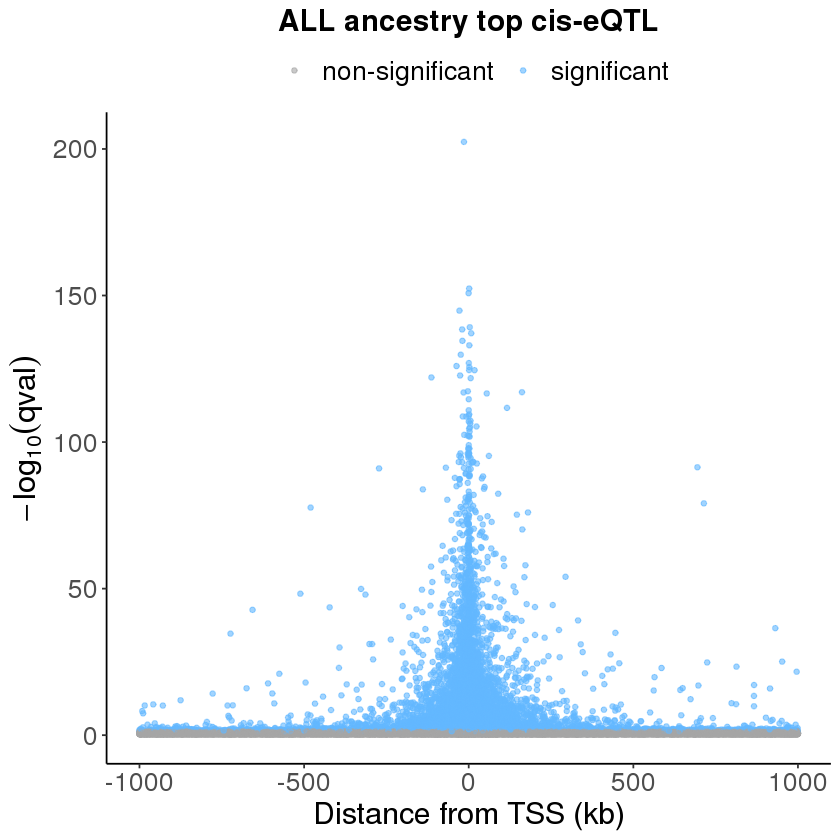

In [16]:
p <- ggplot(all_assoc, aes(x = dist_kb)) +
    geom_point(aes(y = -log10(qval), color = sig), alpha = .6, size = 1.2) +
    labs(x = "Distance from TSS (kb)",
         y = expression(-log[10](qval)),
         title = "ALL ancestry top cis-eQTL",
         color = "") +
    theme_classic() +
    theme(axis.text = element_text(size = 16),
        axis.title = element_text(size = 18),
        plot.title = element_text(size = 18, face="bold", hjust = 0.5),
        legend.text = element_text(size = 16),
        legend.title = element_text(size = 16),
         legend.position = "top") +
    scale_color_manual(values=c("grey65", "steelblue1")) 
p

In [58]:
ggsave("figures/mixed_dtss_p.png", p, width = 6, height = 6)

In [32]:
# eur_sig$dist_kb <- eur_sig$dist/1000
# p1 <- ggplot(eur_sig, aes(x = dist_kb)) +
#     geom_density(color = "blue", size = 1) +
#     labs(x = "Distance from TSS (kb)",
#          title = "EUR top cis-eQTL") +
#     theme_classic() +
#     theme(axis.text = element_text(size=10),
#         axis.title = element_text(size=12),
#         plot.title = element_text(size=16, face="bold", hjust = 0.5),
#         plot.subtitle = element_text(size=14, hjust = 0.5))
# p1
# ggsave("figures/eur_dist.png", p1, height = 6, width = 6)

In [30]:
all_assoc_eur <- all_assoc_eur %>% mutate(sig = ifelse(qval <= 0.05, "significant", "non-significant"))
table(all_assoc_eur$sig)
length(unique(all_assoc_eur$pid))
all_assoc_eur <- all_assoc_eur %>% mutate(dist_kb = dist/1000)
all_assoc_eur$sig <- as.factor(all_assoc_eur$sig)


non-significant     significant 
          26235            5296 

[1] 31531

In [31]:
# amr_sig$dist_kb <- amr_sig$dist/1000
# p2 <- ggplot(amr_sig, aes(x = dist_kb)) +
#     geom_density(color = "blue", size = 1) +
#     labs(x = "Distance from TSS (kb)",
#          title = "AMR top cis-eQTL") +
#     theme_classic() +
#     theme(axis.text = element_text(size=10),
#         axis.title = element_text(size=12),
#         plot.title = element_text(size=16, face="bold", hjust = 0.5),
#         plot.subtitle = element_text(size=14, hjust = 0.5))
# p2
# ggsave("figures/amr_dist.png", p2, height = 6, width = 6)

In [34]:
all_assoc_amr <- all_assoc_amr %>% mutate(sig = ifelse(qval <= 0.05, "significant", "non-significant"))
table(all_assoc_amr$sig)
length(unique(all_assoc_amr$pid))
all_assoc_amr <- all_assoc_amr %>% mutate(dist_kb = dist/1000)
all_assoc_amr$sig <- as.factor(all_assoc_amr$sig)


non-significant     significant 
          28289            3242 

[1] 31531

In [35]:
# afr_sig$dist_kb <- afr_sig$dist/1000
# p3 <- ggplot(afr_sig, aes(x = dist_kb)) +
#     geom_density(color = "blue", size = 1) +
#     labs(x = "Distance from TSS (kb)",
#          title = "AFR top cis-eQTL") +
#     theme_classic() +
#     theme(axis.text = element_text(size=10),
#         axis.title = element_text(size=12),
#         plot.title = element_text(size=16, face="bold", hjust = 0.5),
#         plot.subtitle = element_text(size=14, hjust = 0.5))
# p3
# ggsave("figures/afr_dist.png", p3, height = 6, width = 6)

In [36]:
all_assoc_afr <- all_assoc_afr %>% mutate(sig = ifelse(qval <= 0.05, "significant", "non-significant"))
table(all_assoc_afr$sig)
length(unique(all_assoc_afr$pid))
all_assoc_afr <- all_assoc_afr %>% mutate(dist_kb = dist/1000)
all_assoc_afr$sig <- as.factor(all_assoc_afr$sig)


non-significant     significant 
          29655            1876 

[1] 31531

In [37]:
all_assoc_eur_amr_afr <- rbind(all_assoc_eur, all_assoc_amr, all_assoc_afr)
all_assoc_eur_amr_afr$ancestry <- c(rep("EUR", nrow(all_assoc_eur)), 
                                    rep("AMR", nrow(all_assoc_amr)), 
                                    rep("AFR", nrow(all_assoc_afr)))
all_assoc_eur_amr_afr$ancestry <- factor(all_assoc_eur_amr_afr$ancestry, levels = c("EUR", "AMR", "AFR"))

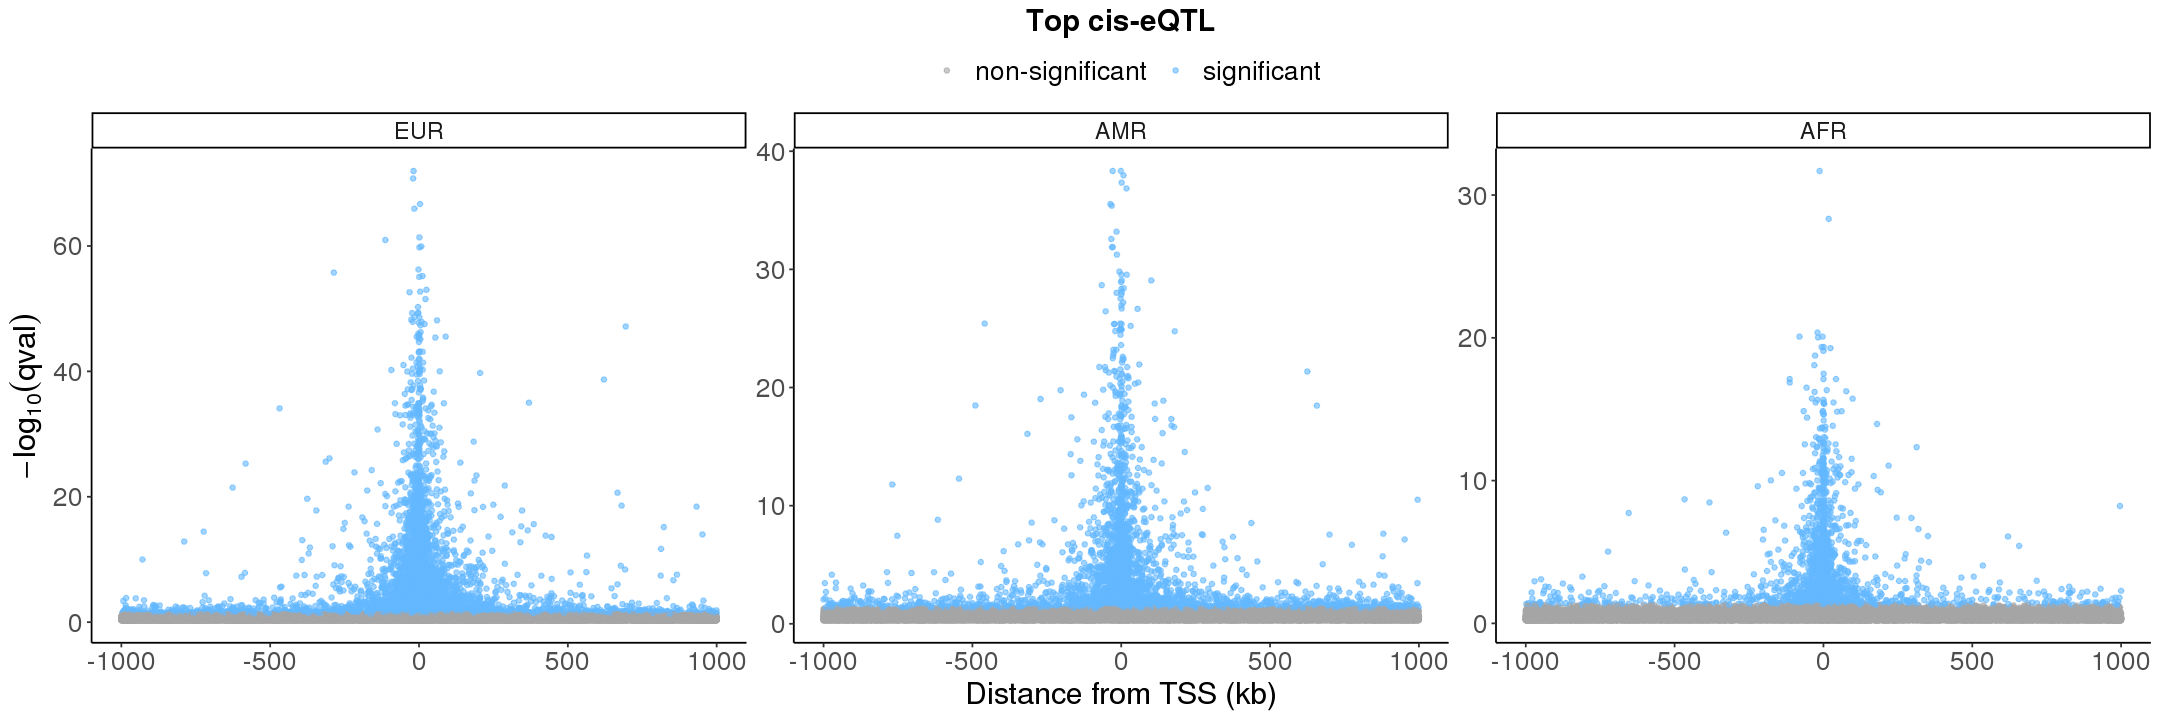

In [34]:
options(repr.plot.width=18, repr.plot.height=6)
p3 <- ggplot(all_assoc_eur_amr_afr, aes(x = dist_kb)) +
    geom_point(aes(y = -log10(qval), color = sig), alpha = .6, size = 1.2) +
    facet_wrap (~ancestry, scales = "free") +
    labs(x = "Distance from TSS (kb)",
         y = expression(-log[10](qval)),
         title = "Top cis-eQTL",
         color = "") +
    theme_classic() +
    theme(axis.text = element_text(size = 16),
        axis.title = element_text(size = 18),
        plot.title = element_text(size = 18, face = "bold", hjust = 0.5),
        legend.text = element_text(size = 16),
        legend.title = element_text(size = 16),
         legend.position = "top",
         strip.text.x = element_text(size = 14)) +
    scale_color_manual(values=c("grey65", "steelblue1")) 
p3

In [35]:
ggsave("figures/dist.png", p3, height = 6, width = 18)

### 8: Ancestry eGene UpsetR; concordance/correlation of eQTL effect direction

** Correlation of eQTL effect size; Spearman correlation; use `abs(slope)`; try both nominal and permuted associations **

** Nominal **

In [4]:
mixed_nominal <- fread("results/mixed_nominal_90hcp/significant_assoc.txt", data.table = F)
eur_nominal <- fread("results/eur_nominal_50HCP/significant_assoc.txt", data.table = F)
amr_nominal <- fread("results/amr_nominal_15HCP/significant_assoc.txt", data.table = F)
afr_nominal <- fread("results/afr_nominal_25HCP/significant_assoc.txt", data.table = F)

In [5]:
mixed_nominal <- mixed_nominal %>% unite("gene_snp", pid, sid, sep = "-", remove = FALSE)
eur_nominal <- eur_nominal %>% unite("gene_snp", pid, sid, sep = "-", remove = FALSE)
amr_nominal <- amr_nominal %>% unite("gene_snp", pid, sid, sep = "-", remove = FALSE)
afr_nominal <- afr_nominal %>% unite("gene_snp", pid, sid, sep = "-", remove = FALSE)

In [6]:
# mixed, eur
mixed_eur <- mixed_nominal %>% inner_join(eur_nominal, by = "gene_snp")
mixed_eur_corr <- cor.test(x = abs(mixed_eur$slope.x), y = abs(mixed_eur$slope.y), method = 'spearman')
mixed_eur_corr

Warning message in cor.test.default(x = abs(mixed_eur$slope.x), y = abs(mixed_eur$slope.y), :
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  abs(mixed_eur$slope.x) and abs(mixed_eur$slope.y)
S = 2.7683e+15, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.9002463 


In [7]:
# mixed, amr
mixed_amr <- mixed_nominal %>% inner_join(amr_nominal, by = "gene_snp")
mixed_amr_corr <- cor.test(x = abs(mixed_amr$slope.x), y = abs(mixed_amr$slope.y), method = 'spearman')

Warning message in cor.test.default(x = abs(mixed_amr$slope.x), y = abs(mixed_amr$slope.y), :
“Cannot compute exact p-value with ties”


In [8]:
# mixed, afr
mixed_afr <- mixed_nominal %>% inner_join(afr_nominal, by = "gene_snp")
mixed_afr_corr <- cor.test(x = abs(mixed_afr$slope.x), y = abs(mixed_afr$slope.y), method = 'spearman')

Warning message in cor.test.default(x = abs(mixed_afr$slope.x), y = abs(mixed_afr$slope.y), :
“Cannot compute exact p-value with ties”


In [9]:
# eur, amr
eur_amr <- eur_nominal %>% inner_join(amr_nominal, by = "gene_snp")
eur_amr_corr <- cor.test(x = abs(eur_amr$slope.x), y = abs(eur_amr$slope.y), method = 'spearman')

Warning message in cor.test.default(x = abs(eur_amr$slope.x), y = abs(eur_amr$slope.y), :
“Cannot compute exact p-value with ties”


In [10]:
# eur, afr
eur_afr <- eur_nominal %>% inner_join(afr_nominal, by = "gene_snp")
eur_afr_corr <- cor.test(x = abs(eur_afr$slope.x), y = abs(eur_afr$slope.y), method = 'spearman')

Warning message in cor.test.default(x = abs(eur_afr$slope.x), y = abs(eur_afr$slope.y), :
“Cannot compute exact p-value with ties”


In [11]:
# amr, afr
amr_afr <- amr_nominal %>% inner_join(afr_nominal, by = "gene_snp")
amr_afr_corr <- cor.test(x = abs(amr_afr$slope.x), y = abs(amr_afr$slope.y), method = 'spearman')

Warning message in cor.test.default(x = abs(amr_afr$slope.x), y = abs(amr_afr$slope.y), :
“Cannot compute exact p-value with ties”


In [12]:
df <- data.frame("group1" = c(rep("ALL", 4), rep("EUR", 3), rep("AMR", 2), "AFR"),
                 "group2" = c("ALL", "EUR", "AMR", "AFR", "EUR", "AMR", "AFR", "AMR", "AFR", "AFR"),
                 "rho" = c(1, mixed_eur_corr$estimate, mixed_amr_corr$estimate, mixed_afr_corr$estimate, 
                           1, eur_amr_corr$estimate, eur_afr_corr$estimate, 
                           1, amr_afr_corr$estimate, 
                           1),
                 "shared" = c(nrow(mixed_nominal), nrow(mixed_eur), nrow(mixed_amr), nrow(mixed_afr),
                             nrow(eur_nominal), nrow(eur_amr), nrow(eur_afr),
                             nrow(amr_nominal), nrow(amr_afr),
                             nrow(afr_nominal)))

In [13]:
df <- df %>% mutate(display = paste0(signif(rho,4), "\n(", shared, ")"))
df

group1,group2,rho,shared,display
<fct>,<fct>,<dbl>,<int>,<chr>
ALL,ALL,1.0000000,1485926,1 (1485926)
ALL,EUR,0.9002463,550147,0.9002 (550147)
ALL,AMR,0.8663770,260898,0.8664 (260898)
ALL,AFR,0.8596972,101923,0.8597 (101923)
EUR,EUR,1.0000000,685228,1 (685228)
EUR,AMR,0.8118011,185914,0.8118 (185914)
EUR,AFR,0.7953373,64038,0.7953 (64038)
AMR,AMR,1.0000000,314559,1 (314559)
AMR,AFR,0.8227086,61227,0.8227 (61227)


In [14]:
df$group1 <- factor(df$group1, levels = c("ALL", "EUR", "AMR", "AFR"))
df$group2 <- factor(df$group2, levels = c("ALL", "EUR", "AMR", "AFR"))

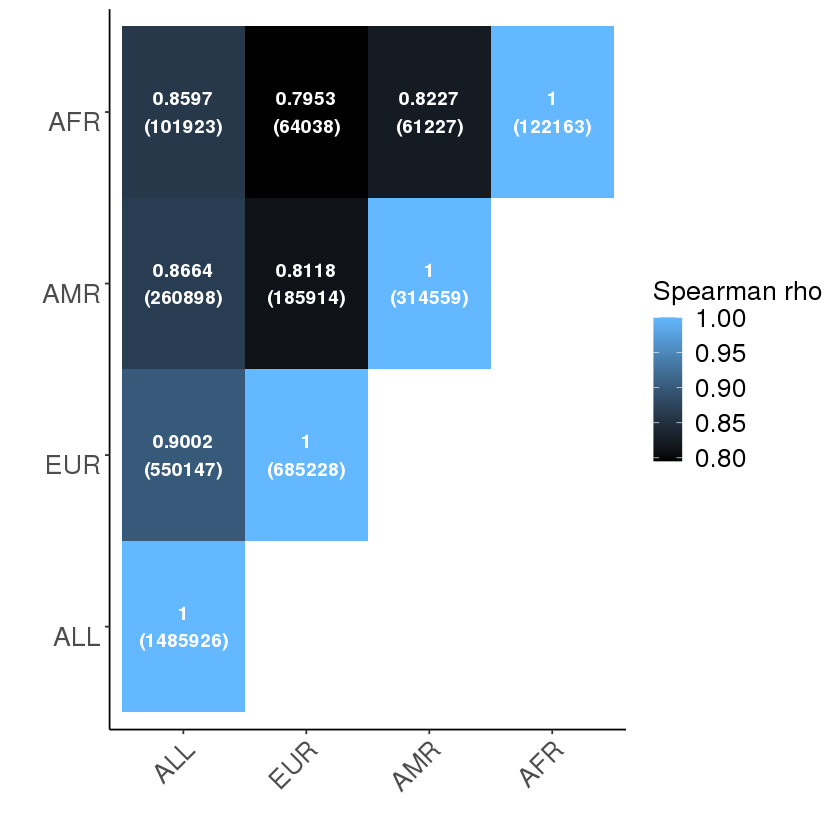

In [15]:
p <- ggplot(df, aes(x = group1, y = group2, fill = rho)) +
    geom_tile() +
 scale_fill_gradient( 
   name = "Spearman rho",
   low = "black", high = "steelblue1") +
 theme_classic() + 
 labs(x = "", y = "") +
 theme(axis.text.x = element_text(angle = 45, vjust = 1, 
    size = 16, hjust = 1),
       axis.text.y = element_text(vjust = 1, 
    size = 16, hjust = 1),
       axis.title = element_text(size = 18),
       plot.title = element_text(size = 18, face = "bold", hjust = 0.5),
      legend.title = element_text(size = 16),
      legend.text = element_text(size = 16),
      legend.position = "right") +
#  ggtitle("Correlation of nominal eQTL effect size") +
 geom_text(aes(label = display), color = "white", size = 4, fontface = "bold") 
p

In [16]:
ggsave("figures/corr_nominal.png", p, width = 6, height = 6)

** Permuted **

If finished full list of QTL from permutations, could calculate correlation from that. Now only studying pairs of gene and top cis-SNP.

In [5]:
mixed_sig <- mixed_sig %>% unite("gene_snp", pid, sid, sep = "-",remove = FALSE)
eur_sig <- eur_sig %>% unite("gene_snp", pid, sid, sep = "-", remove = FALSE)
amr_sig <- amr_sig %>% unite("gene_snp", pid, sid, sep = "-", remove = FALSE)
afr_sig <- afr_sig %>% unite("gene_snp", pid, sid, sep = "-", remove = FALSE)

In [5]:
mixed_eur <- mixed_sig %>% inner_join(eur_sig, by = "gene_snp")
mixed_eur_corr <- cor.test(x = abs(mixed_eur$slope.x), y = abs(mixed_eur$slope.y), method = 'spearman')

mixed_amr <- mixed_sig %>% inner_join(amr_sig, by = "gene_snp")
mixed_amr_corr <- cor.test(x = abs(mixed_amr$slope.x), y = abs(mixed_amr$slope.y), method = 'spearman')

mixed_afr <- mixed_sig %>% inner_join(afr_sig, by = "gene_snp")
mixed_afr_corr <- cor.test(x = abs(mixed_afr$slope.x), y = abs(mixed_afr$slope.y), method = 'spearman')

eur_amr <- eur_sig %>% inner_join(amr_sig, by = "gene_snp")
eur_amr_corr <- cor.test(x = abs(eur_amr$slope.x), y = abs(eur_amr$slope.y), method = 'spearman')

eur_afr <- eur_sig %>% inner_join(afr_sig, by = "gene_snp")
eur_afr_corr <- cor.test(x = abs(eur_afr$slope.x), y = abs(eur_afr$slope.y), method = 'spearman')

amr_afr <- amr_sig %>% inner_join(afr_sig, by = "gene_snp")
amr_afr_corr <- cor.test(x = abs(amr_afr$slope.x), y = abs(amr_afr$slope.y), method = 'spearman')

Warning message in cor.test.default(x = abs(mixed_eur$slope.x), y = abs(mixed_eur$slope.y), :
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(x = abs(mixed_amr$slope.x), y = abs(mixed_amr$slope.y), :
“Cannot compute exact p-value with ties”


In [22]:
df <- data.frame("group1" = c(rep("ALL", 4), rep("EUR", 3), rep("AMR", 2), "AFR"),
                 "group2" = c("ALL", "EUR", "AMR", "AFR", "EUR", "AMR", "AFR", "AMR", "AFR", "AFR"),
                 "rho" = c(1, mixed_eur_corr$estimate, mixed_amr_corr$estimate, mixed_afr_corr$estimate, 
                           1, eur_amr_corr$estimate, eur_afr_corr$estimate, 
                           1, amr_afr_corr$estimate, 
                           1),
                 "shared" = c(nrow(mixed_sig), nrow(mixed_eur), nrow(mixed_amr), nrow(mixed_afr),
                             nrow(eur_sig), nrow(eur_amr), nrow(eur_afr),
                             nrow(amr_sig), nrow(amr_afr),
                             nrow(afr_sig)))

In [23]:
df <- df %>% mutate(display = paste0(signif(rho,4), "\n(", shared, ")"))
df$group1 <- factor(df$group1, levels = c("ALL", "EUR", "AMR", "AFR"))
df$group2 <- factor(df$group2, levels = c("ALL", "EUR", "AMR", "AFR"))

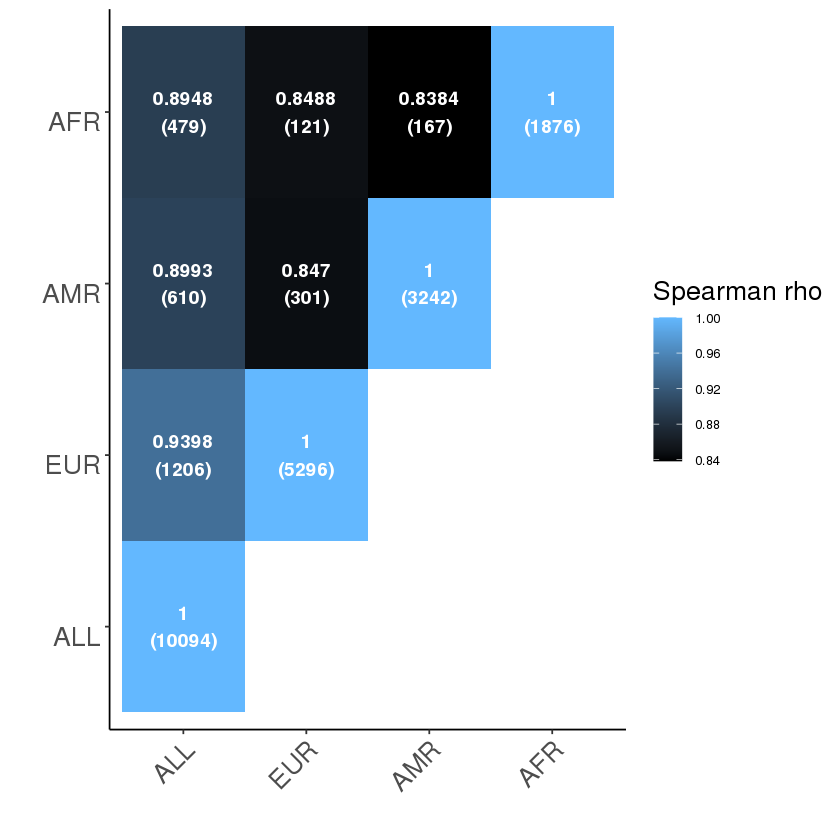

In [28]:
p <- ggplot(df, aes(x = group1, y = group2, fill = rho)) +
    geom_tile() +
 scale_fill_gradient( 
   name="Spearman rho",
   low = "black", high = "steelblue1") +
 theme_classic() + 
 labs(x = "", y = "") +
 theme(axis.text.x = element_text(angle = 45, vjust = 1, 
    size = 16, hjust = 1),
       axis.text.y = element_text(vjust = 1, 
    size = 16, hjust = 1),
       axis.title = element_text(size = 18),
       plot.title = element_text(size = 18, face = "bold", hjust = 0.5),
      legend.title = element_text(size = 16),
      legend.text = element_text(size = 8),
      legend.position = "right") +
#  ggtitle("Correlation of permutation eQTL effect size") +
 geom_text(aes(label = display), color = "white", size = 4, fontface = "bold") 
p

In [29]:
ggsave("figures/corr_perm.png", p, width = 6, height = 6)

In [46]:
df %>% filter(group1 != group2) %>% summarise(mean(rho))

mean(rho)
<dbl>
0.8780094


** RW 2019, perm and nominal **

In [89]:
walker <- fread("../shareQTL/walker_sum_stats/final_eqtls.txt", data.table = F) %>% filter(st < 0.05)
length(unique(walker$pid))

[1] 6546

In [90]:
sum(duplicated(walker))

[1] 0

In [92]:
walker <- walker %>% 
    unite('snpID', sid_chr, sid_pos, sep = ':') %>% 
    unite('gene_snpID', pid, snpID, sep = '-', remove = FALSE)

In [93]:
dim(walker)

[1] 6549    8

In [94]:
sum(duplicated(walker$gene_snpID))

[1] 3

In [95]:
walker[duplicated(walker$gene_snpID),]

,gene_snpID,pid,sid,npval,bpval,bonferroni,st,snpID
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
3814,ENSG00000159256-21:37692589,ENSG00000159256,21_37692589_A_T,5.56898e-07,1.49510e-03,1,0.0021374040,21:37692589
4163,ENSG00000011566-2:40473425,ENSG00000011566,2_40473425_A_G,2.99564e-05,4.11457e-02,1,0.0364786923,2:40473425
5479,ENSG00000112304-6:24683150,ENSG00000112304,6_24683150_G_A,2.90711e-08,9.89123e-05,1,0.0001828332,6:24683150


In [96]:
walker %>% filter(gene_snpID %in% walker[duplicated(walker$gene_snpID),'gene_snpID'])

gene_snpID,pid,sid,npval,bpval,bonferroni,st,snpID
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
ENSG00000159256-21:37692589,ENSG00000159256,21_37692589_A_T,5.56898e-07,1.23166e-03,1,0.0017942211,21:37692589
ENSG00000159256-21:37692589,ENSG00000159256,21_37692589_A_T,5.56898e-07,1.49510e-03,1,0.0021374040,21:37692589
ENSG00000011566-2:40473425,ENSG00000011566,2_40473425_A_G,2.99564e-05,4.33965e-02,1,0.0380540185,2:40473425
ENSG00000011566-2:40473425,ENSG00000011566,2_40473425_A_G,2.99564e-05,4.11457e-02,1,0.0364786923,2:40473425
ENSG00000112304-6:24683150,ENSG00000112304,6_24683150_G_A,2.90711e-08,1.39540e-04,1,0.0002504907,6:24683150
ENSG00000112304-6:24683150,ENSG00000112304,6_24683150_G_A,2.90711e-08,9.89123e-05,1,0.0001828332,6:24683150


In [97]:
walker <- walker[!duplicated(walker$gene_snpID),]

In [73]:
mixed_sig <- mixed_sig %>% 
    left_join(variant, by = c('sid' = 'V3')) %>%
    unite('snpID', V1, V2, sep = ":") %>% 
    unite('gene_snpID', pid, snpID, sep = '-', remove = FALSE)
head(mixed_sig)

,gene_snp,gene_snpID,pid,nvar,shape1,shape2,dummy,sid,dist,npval,slope,ppval,bpval,qval,pval_nominal_threshold,snpID
,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,ENSG00000000419-rs192563417,ENSG00000000419-20:50360188,ENSG00000000419,6979,1.02134,1367.680,476.819,rs192563417,785096,1.36171e-07,-0.505097,0.00079992,6.71442e-04,1.47123e-03,2.90212e-05,20:50360188
2,ENSG00000000460-rs17529513,ENSG00000000460-1:169798745,ENSG00000000460,7370,1.03366,743.049,467.386,rs17529513,167500,1.08049e-22,-0.302487,0.00009999,6.83032e-18,5.86726e-17,5.58582e-05,1:169798745
3,ENSG00000001036-rs4896658,ENSG00000001036-6:143785199,ENSG00000001036,5683,1.04787,948.786,469.456,rs4896658,-47658,1.77472e-07,-0.588128,0.00069993,5.90912e-04,1.30931e-03,4.60076e-05,6:143785199
4,ENSG00000001460-rs760969,ENSG00000001460-1:24745704,ENSG00000001460,5648,1.04183,862.516,466.170,rs760969,2280,1.34110e-62,-0.657378,0.00009999,1.67187e-54,8.74000e-53,4.95438e-05,1:24745704
5,ENSG00000001461-rs497071,ENSG00000001461-1:24713833,ENSG00000001461,5648,1.04028,804.007,459.959,rs497071,-28459,3.82613e-21,-0.304292,0.00009999,2.93508e-16,2.26687e-15,5.28578e-05,1:24713833
6,ENSG00000001561-rs34269469,ENSG00000001561-6:46118052,ENSG00000001561,5517,1.03939,749.126,465.199,rs34269469,20326,1.39239e-12,0.129466,0.00009999,1.17992e-08,4.79713e-08,5.65509e-05,6:46118052


In [98]:
sum(unique(mixed_sig$pid) %in% unique(walker$pid))

[1] 4631

png 
  2

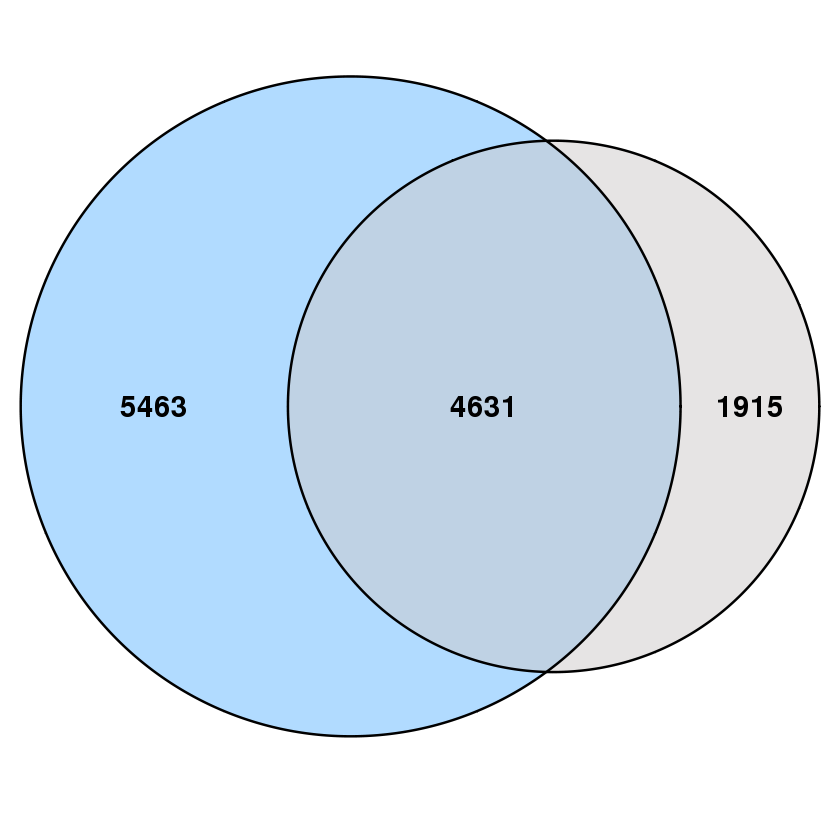

In [6]:
# fetal-walker, perm
venn.plot <- draw.pairwise.venn(10094, 6546, 4631, fill=c("steelblue1", "snow3"),
                                alpha=c(0.5,0.5), cex=1.5, fontface=2, fontfamily=rep("sans",3),
                                cat.cex=1.5,cat.fontface=2, cat.pos=c(-150,150),cat.dist=rep(.05,2),
                                cat.fontfamily=rep("sans",2), 
                                category=c("", ""))
pdf("figures/walker_fetal.pdf", width = 4, height = 4)
grid.draw(venn.plot)
dev.off()

In [99]:
walker_fetal <- mixed_sig %>% inner_join(walker, by = c('gene_snpID' = 'gene_snpID'))
dim(walker_fetal)
sum(mixed_sig$gene_snpID %in% walker$gene_snpID)
names(walker_fetal)

[1] 561  23

[1] 561

[1] "gene_snp"               "gene_snpID"             "pid.x"                 
 [4] "nvar"                   "shape1"                 "shape2"                
 [7] "dummy"                  "sid.x"                  "dist"                  
[10] "npval.x"                "slope"                  "ppval"                 
[13] "bpval.x"                "qval"                   "pval_nominal_threshold"
[16] "snpID.x"                "pid.y"                  "sid.y"                 
[19] "npval.y"                "bpval.y"                "bonferroni"            
[22] "st"                     "snpID.y"

In [101]:
# walker perm does not have slope. 
walker_nominal <- fread("../shareQTL/walker_sum_stats/fetal_fdr.05_info.txt", data.table = F) %>% 
    unite('snpID', V7, V8, sep = ':') %>% 
    unite('gene_snpID', V1, snpID, sep = '-', remove = FALSE)
head(walker_nominal)

,gene_snpID,V1,V2,V3,V4,V5,V6,snpID,V9,V10
,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
1,ENSG00000120029-10:102627788,ENSG00000120029,10_102627788_A_G,-977569,3.00915e-04,-0.270141,0.02987263,10:102627788,A,G
2,ENSG00000120029-10:102636605,ENSG00000120029,10_102636605_C_T,-968752,1.34882e-04,-0.322916,0.01581471,10:102636605,C,T
3,ENSG00000120029-10:102639275,ENSG00000120029,10_102639275_C_A,-966082,3.34480e-04,-0.329542,0.03246384,10:102639275,C,A
4,ENSG00000120029-10:102640249,ENSG00000120029,10_102640249_T_A,-965108,2.23670e-04,-0.342236,0.02364232,10:102640249,T,A
5,ENSG00000166189-10:103557095,ENSG00000166189,10_103557095_T_A,-268053,9.89776e-05,-0.380545,0.01228260,10:103557095,T,A
6,ENSG00000166189-10:103558261,ENSG00000166189,10_103558261_G_A,-266887,9.43862e-05,-0.371782,0.01181349,10:103558261,G,A


In [104]:
length(unique(walker_nominal$V1))

[1] 11625

In [103]:
walker_nominal %>% filter(gene_snpID %in% walker_nominal[duplicated(walker_nominal$gene_snpID),'gene_snpID'])

gene_snpID,V1,V2,V3,V4,V5,V6,snpID,V9,V10
<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
ENSG00000159256-21:36841246,ENSG00000159256,21_36841246_G_A,-851242,2.24591e-04,0.206091,0.0237174541,21:36841246,G,A
ENSG00000159256-21:37692589,ENSG00000159256,21_37692589_A_T,101,5.56898e-07,-0.304915,0.0001367352,21:37692589,A,T
ENSG00000159256-21:37695473,ENSG00000159256,21_37695473_C_T,2985,2.18422e-04,-0.181407,0.0231993537,21:37695473,C,T
ENSG00000159256-21:37700241,ENSG00000159256,21_37700241_C_G,7753,8.63423e-05,-0.202838,0.0109746324,21:37700241,C,G
ENSG00000159256-21:37702215,ENSG00000159256,21_37702215_C_G,9727,4.90261e-04,-0.178070,0.0435585769,21:37702215,C,G
ENSG00000159256-21:37702279,ENSG00000159256,21_37702279_A_G,9791,1.80427e-06,-0.303185,0.0003898145,21:37702279,A,G
ENSG00000159256-21:37707768,ENSG00000159256,21_37707768_C_T,15280,2.35482e-04,-0.182744,0.0246317270,21:37707768,C,T
ENSG00000159256-21:37709639,ENSG00000159256,21_37709639_G_A,17151,3.11943e-04,-0.178483,0.0307377233,21:37709639,G,A
ENSG00000159256-21:37716157,ENSG00000159256,21_37716157_A_G,23669,9.21995e-05,-0.198988,0.0115843903,21:37716157,A,G


In [105]:
walker_nominal %>% filter(gene_snpID == 'ENSG00000159256-21:36841246')

gene_snpID,V1,V2,V3,V4,V5,V6,snpID,V9,V10
<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
ENSG00000159256-21:36841246,ENSG00000159256,21_36841246_G_A,-851242,0.000224591,0.206091,0.02371745,21:36841246,G,A
ENSG00000159256-21:36841246,ENSG00000159256,21_36841246_G_A,-851242,0.000224591,0.206091,0.02371745,21:36841246,G,A


In [106]:
walker_nominal <- walker_nominal[!duplicated(walker_nominal$gene_snpID),]
length(unique(walker_nominal$V1))

[1] 11625

In [107]:
sum(unique(mixed_nominal$pid) %in% unique(walker_nominal$V1))

[1] 9542

png 
  2

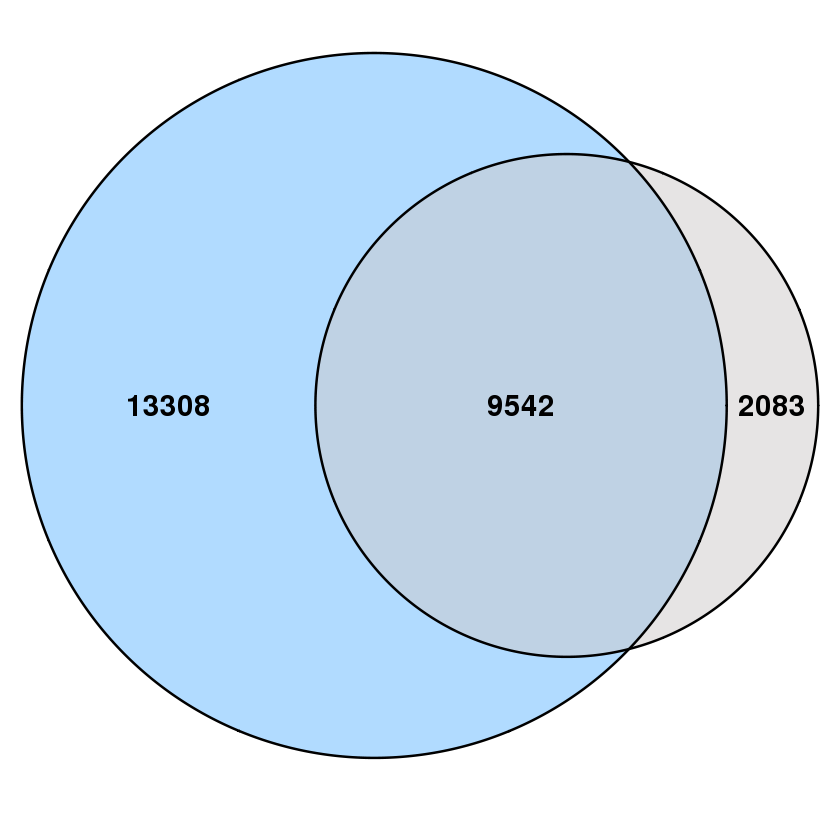

In [7]:
# fetal-walker, nominals
venn.plot <- draw.pairwise.venn(22850, 11625, 9542, fill=c("steelblue1", "snow3"),
                                alpha=c(0.5,0.5), cex=1.5, fontface=2, fontfamily=rep("sans",3),
                                cat.cex=1.5,cat.fontface=2, cat.pos=c(-150,150),cat.dist=rep(.05,2),
                                cat.fontfamily=rep("sans",2), 
                                category=c("", ""))
pdf("figures/walker_fetal_nominal.pdf", width = 4, height = 4)
grid.draw(venn.plot)
dev.off()

In [108]:
walker_nominal_fetal <- mixed_nominal %>% inner_join(walker_nominal, by = c('gene_snpID' = 'gene_snpID'))
dim(walker_nominal_fetal)
sum(mixed_nominal$gene_snpID %in% walker_nominal$gene_snpID)
sum(walker_nominal$gene_snpID %in% mixed_nominal$gene_snpID)
names(walker_nominal_fetal)

[1] 357302     18

[1] 357302

[1] 357302

[1] "gene_snp"   "gene_snpID" "pid"        "sid"        "dist"      
 [6] "npval"      "slope"      "fdr"        "snpID.x"    "V1"        
[11] "V2"         "V3"         "V4"         "V5"         "V6"        
[16] "snpID.y"    "V9"         "V10"

In [110]:
cor(abs(walker_nominal_fetal$slope), abs(walker_nominal_fetal$V5), method = 'spearman')

[1] 0.7948691

### 10: eGene types

In [8]:
annot <- fread("../salmon/gencode.v33lift37.annotation.gene.info.tsv", data.table=F)

In [11]:
mixed_sig <- mixed_sig %>% left_join(annot, by=c("pid"="ensg"))

In [12]:
dim(mixed_sig)

[1] 10094    26

In [13]:
mixed_sig <- mixed_sig[,c(1:14, 25, 26)]

In [15]:
colnames(mixed_sig)[15] <- "gene_type"
colnames(mixed_sig)[16] <- "gene_name"
head(mixed_sig)

,pid,nvar,shape1,shape2,dummy,sid,dist,npval,slope,ppval,bpval,qval,pval_nominal_threshold,dist_kb,gene_type,gene_name
,<chr>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,ENSG00000000419,6979,1.02134,1367.680,476.819,rs192563417,785096,1.36171e-07,-0.505097,0.00079992,6.71442e-04,1.47123e-03,2.90212e-05,785.096,protein_coding,DPM1
2,ENSG00000000460,7370,1.03366,743.049,467.386,rs17529513,167500,1.08049e-22,-0.302487,0.00009999,6.83032e-18,5.86726e-17,5.58582e-05,167.500,protein_coding,C1orf112
3,ENSG00000001036,5683,1.04787,948.786,469.456,rs4896658,-47658,1.77472e-07,-0.588128,0.00069993,5.90912e-04,1.30931e-03,4.60076e-05,-47.658,protein_coding,FUCA2
4,ENSG00000001460,5648,1.04183,862.516,466.170,rs760969,2280,1.34110e-62,-0.657378,0.00009999,1.67187e-54,8.74000e-53,4.95438e-05,2.280,protein_coding,STPG1
5,ENSG00000001461,5648,1.04028,804.007,459.959,rs497071,-28459,3.82613e-21,-0.304292,0.00009999,2.93508e-16,2.26687e-15,5.28578e-05,-28.459,protein_coding,NIPAL3
6,ENSG00000001561,5517,1.03939,749.126,465.199,rs34269469,20326,1.39239e-12,0.129466,0.00009999,1.17992e-08,4.79713e-08,5.65509e-05,20.326,protein_coding,ENPP4


In [59]:
# write.table(mixed_sig, "results/mixed_perm_90hcp/sig_pheno_info.txt", col.names=T, row.names=F, quote=F, sep="\t")

In [30]:
df <- as.data.frame(sort(table(mixed_sig$gene_type)))
df <- df[order(df$Freq, decreasing = TRUE),]
df <- df[c(1:4),]
df$Var1 <- as.character(df$Var1)
df[5,] <- c("Other", (10094-6278-2448-378-244))
df <- df %>% mutate(prop = as.numeric(Freq)/10094)
df

Var1,Freq,prop
<chr>,<chr>,<dbl>
protein_coding,6278,0.62195364
lncRNA,2448,0.24252031
processed_pseudogene,378,0.03744799
transcribed_unprocessed_pseudogene,244,0.02417278
Other,746,0.07390529


In [31]:
df$Var1 <- factor(df$Var1, levels = c("protein_coding", "lncRNA", "processed_pseudogene", "transcribed_unprocessed_pseudogene", "Other"))

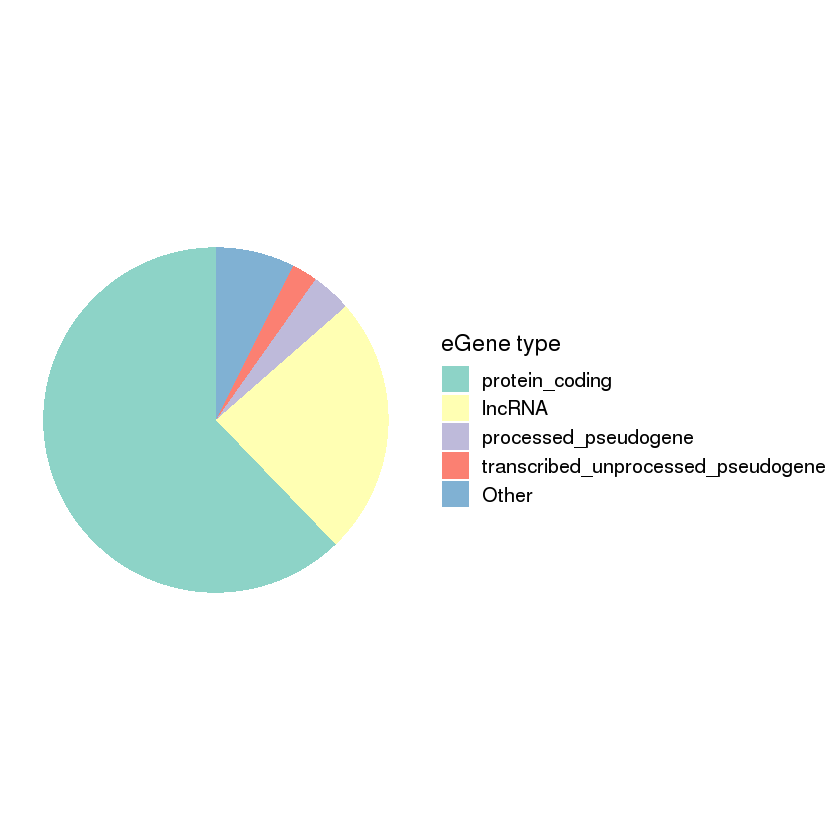

In [32]:
p <- ggplot(df, aes(x="", y=prop, fill=Var1)) +
  geom_bar(width = 1, stat = "identity") +
  coord_polar("y", start = 0) +
  theme_void() +
  theme(legend.text = element_text(size=12),
        legend.title = element_text(size=14)) +
  scale_fill_brewer(palette = "Set3") +
  labs(fill="eGene type")

p 

** Write output file with gene name and gene type for all permutation associations **

Note: w/o `dtss_kb` column

In [18]:
all_assoc <- all_assoc %>% left_join(annot, by=c("pid"="ensg")) %>% select(c(1:13, 24, 25))
all_assoc_eur <- all_assoc_eur %>% left_join(annot, by=c("pid"="ensg")) %>% select(c(1:13, 24, 25))
all_assoc_amr <- all_assoc_amr %>% left_join(annot, by=c("pid"="ensg")) %>% select(c(1:13, 24, 25))
all_assoc_afr <- all_assoc_afr %>% left_join(annot, by=c("pid"="ensg")) %>% select(c(1:13, 24, 25))

In [25]:
colnames(all_assoc)[14] <- "gene_type"
colnames(all_assoc)[15] <- "gene_name"
colnames(all_assoc_eur)[14] <- "gene_type"
colnames(all_assoc_eur)[15] <- "gene_name"
colnames(all_assoc_amr)[14] <- "gene_type"
colnames(all_assoc_amr)[15] <- "gene_name"
colnames(all_assoc_afr)[14] <- "gene_type"
colnames(all_assoc_afr)[15] <- "gene_name"

In [28]:
write.table(all_assoc, "results/mixed_perm_90hcp/all_assoc_perm_info.txt", 
            col.names = T, row.names = F, quote = F, sep = "\t")
write.table(all_assoc_eur, "results/eur_perm_50HCP/all_assoc_perm_info.txt", 
            col.names = T, row.names = F, quote = F, sep = "\t")
write.table(all_assoc_amr, "results/amr_perm_15HCP/all_assoc_perm_info.txt", 
            col.names = T, row.names = F, quote = F, sep = "\t")
write.table(all_assoc_afr, "results/afr_perm_25HCP/all_assoc_perm_info.txt", 
            col.names = T, row.names = F, quote = F, sep = "\t")

### 11: Conditional cis-eQTL

**Top variants per rank of all expressed genes**

In [3]:
dat <- fread("results/mixed_conditional_90hcp/conditional_top_variants.txt", data.table = F)

Check TSS
- For SNP, V10==V11, start==end, V10==V3+V7
- For indels, variant start and end position correspond to the indel, V11==V3+V7; sometimes V10==V3+V7

In [39]:
dim(dat)
sum(dat$V3+dat$V7==dat$V10)
sum(dat$V3+dat$V7==dat$V11)
sum(!(dat$V3+dat$V7) %in% c(dat$V10, dat$V11))

[1] 16568    20

[1] 16024

[1] 16020

[1] 0

In [5]:
head(dat %>% filter(V7==0))

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20
,<chr>,<int>,<int>,<int>,<chr>,<int>,<int>,<chr>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<int>,<int>
1,ENSG00000267199,18,12438889,12438889,+,7025,0,rs12964631,18,12438889,12438889,0,3.97887e-34,-0.660071,1,1,3.71840e-09,-0.333988,1,1
2,ENSG00000254876,9,100000731,100000731,+,5358,0,rs7856254,9,100000731,100000731,0,2.99875e-22,1.580330,1,1,9.97145e-20,1.487390,1,1


In [6]:
table(dat$V19)
table(dat$V20)


    1 
16568 


    0     1 
   14 16554 

In [10]:
# subset eGenes only
# egene_dat <- read.table("results/mixed_perm_90hcp/sig_pheno.txt",hea = T, stringsAsFactors = F)

**remove variants with backward P-value that is not below the threshold of this feature**

In [4]:
dat <- dat %>% filter(V20 == 1)

**check features with significant conditional QTL are mostly isoforms with permutation eQTL**

In [41]:
length(unique(mixed_sig$pid))
length(unique(dat$V1))
sum(unique(mixed_sig$pid) %in% unique(dat$V1))

[1] 10094

[1] 10980

[1] 9426

**How many ranks/independent QTL each feature has? (+1 because primary QTL is rank 0)**

In [10]:
table(dat$V12)


    0     1     2     3     4     5     6     7     8     9 
10972  3665  1250   438   148    53    18     8     1     1 


   1    2    3    4    5    6    7    8   10 
7312 2413  815  292   95   35   10    7    1 

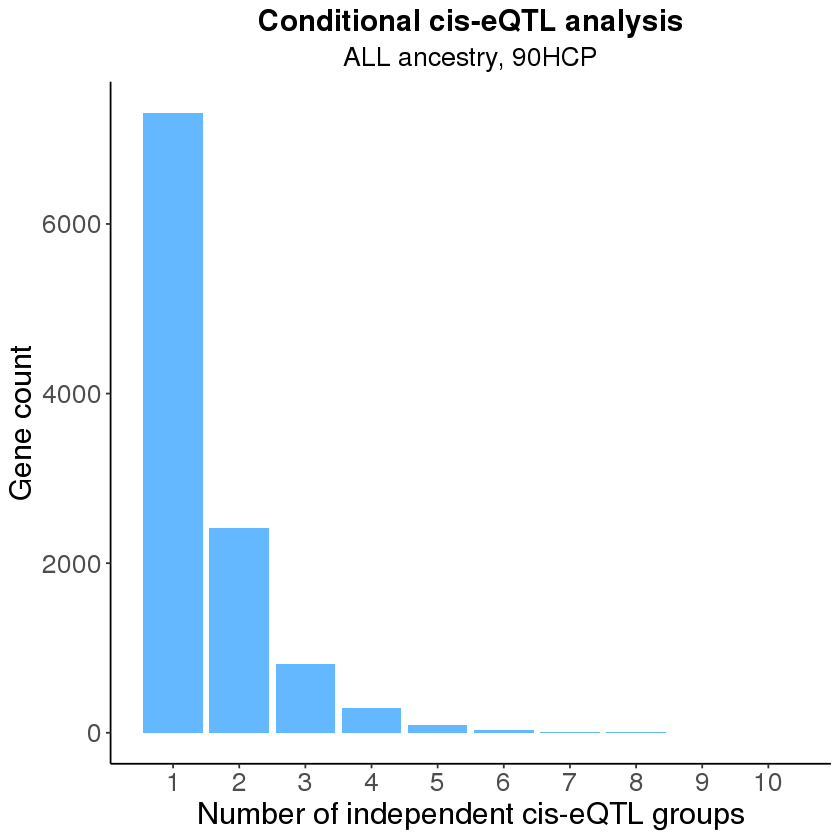

In [89]:
df <- data.frame("gene" <- unique(dat$V1),
                 "num_rank" <- NA)
for (i in 1:nrow(df)) {
  gene <- df[i,1]
  df[i,2] <- max(dat[dat$V1==gene,12]) + 1
}
names(df) <-c("gene","num_rank")
table(df$num_rank)

p <- ggplot(df, aes(x = num_rank)) +
  geom_bar(fill = "steelblue1") +
  scale_x_continuous(breaks = seq(1,10,by=1)) +
  labs(x = "Number of independent cis-eQTL groups", y = "Gene count") +
  ggtitle("Conditional cis-eQTL analysis", subtitle = "ALL ancestry, 90HCP") +
  theme_classic() +
  theme(axis.text = element_text(size = 16),
        axis.title = element_text(size = 18),
        plot.title = element_text(size = 18, face = "bold", hjust=0.5),
        plot.subtitle = element_text(size = 16, hjust = 0.5))
p

In [90]:
ggsave("figures/condition_rank.png", p, height=6, width=6)

**Primary and seconday distance to TSS**

In [42]:
dat2 <- filter(dat,V12 <= 1)
dat2$tss_kb <- dat2$V7/1000

dat2$Rank <- ifelse(dat2$V12==0,"Primary","Secondary")

# p2 <- ggplot(dat2, aes(x=tss_kb, color=Rank)) +
#   geom_density(size=.8) +
#   labs(x="Distance from TSS (kb)") +
#   ggtitle("Conditional cis-eQTL analysis", subtitle = "Combined ancestry, 90HCP") +
#   theme_classic() +
#   theme(axis.text = element_text(size=10),
#         axis.title = element_text(size=12),
#         plot.title = element_text(size=16, face="bold", hjust=0.5),
#         plot.subtitle = element_text(size=14, hjust=0.5))
# p2

In [15]:
# ggsave("figures/condition_dtss.png", p2, height=6, width=6)

In [43]:
table(dat2$Rank)


  Primary Secondary 
    10972      3665 

In [44]:
primary <- dat2 %>% filter(Rank == "Primary")
secondary <- dat2 %>% filter(Rank == "Secondary")

In [45]:
median(primary$tss_kb)
median(secondary$tss_kb)

[1] -0.034

[1] 0.482

**wilcox test on TSS absolute values, primary and secondary**

In [22]:
wilcox.test(abs(primary$tss_kb), abs(secondary$tss_kb), alternative = "two.sided")


	Wilcoxon rank sum test with continuity correction

data:  abs(primary$tss_kb) and abs(secondary$tss_kb)
W = 16103489, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0


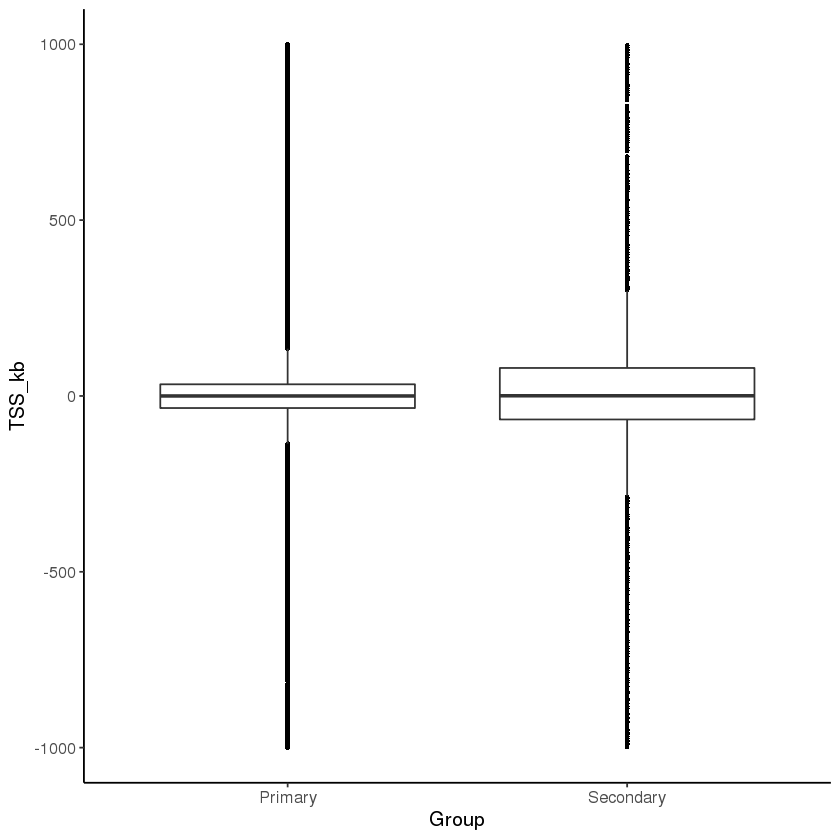

In [23]:
df <- data.frame("Group"=c(rep("Primary", 10972), rep("Secondary", 3665)),
                "TSS_kb"=c(primary$tss_kb, secondary$tss_kb))

ggplot(df, aes(x=Group, y=TSS_kb)) +
    geom_boxplot(outlier.colour = "black", outlier.shape = 16, outlier.size = 1) +
    theme_classic() +
    theme(axis.text = element_text(size=10),
        axis.title = element_text(size=12),
        plot.title = element_text(size=16, face="bold", hjust=0.5),
        plot.subtitle = element_text(size=14, hjust=0.5))

**1st-4th**

In [5]:
dat3 <- filter(dat, V12 <= 3)
dat3$tss_kb <- dat3$V7/1000
dat3 %>% group_by(V12) %>% summarise(median(tss_kb), mean(tss_kb))

V12,median(tss_kb),mean(tss_kb)
<int>,<dbl>,<dbl>
0,-0.0340,2.982923
1,0.4820,-1.127452
2,2.3115,20.702186
3,0.9280,-49.332525


In [6]:
summary(dat$V7)

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-999845.0  -44042.2      34.5    2522.9   46744.0  999905.0 

In [7]:
dat3 <- dat3 %>% mutate(Rank = case_when(V12 == 0 ~ "Primary, median=-0.0340, mean=2.983",
                                 V12 == 1 ~ "Secondary, median=0.4820, mean=-1.127",
                                 V12 == 2 ~ "Tertiary, median=2.3115, mean=20.702",
                                 V12 == 3 ~ "Quaternary, median=0.9280, mean=-49.332"))
table(dat3$Rank)
dat3$Rank <- factor(dat3$Rank, levels = c("Primary, median=-0.0340, mean=2.983", 
                                          "Secondary, median=0.4820, mean=-1.127", 
                                          "Tertiary, median=2.3115, mean=20.702", 
                                          "Quaternary, median=0.9280, mean=-49.332"))


    Primary, median=-0.0340, mean=2.983 Quaternary, median=0.9280, mean=-49.332 
                                  10972                                     438 
  Secondary, median=0.4820, mean=-1.127    Tertiary, median=2.3115, mean=20.702 
                                   3665                                    1250 

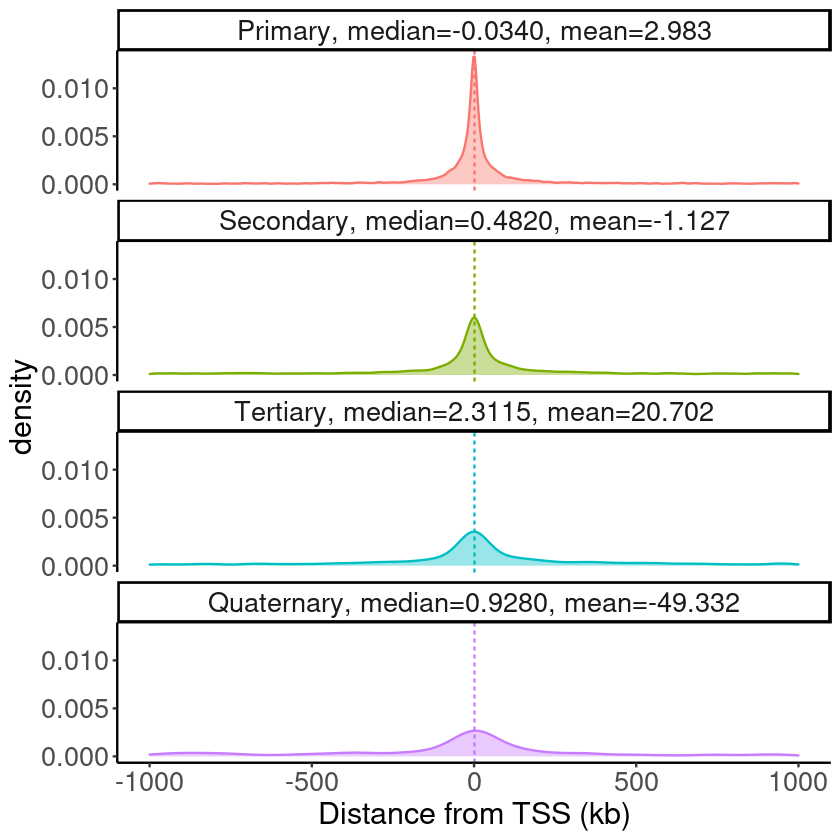

In [8]:
p2 <- ggplot(dat3, aes(x = tss_kb, fill = Rank, color = Rank)) +
  geom_density(alpha = .4) +
  geom_vline(aes(xintercept = median(tss_kb), color = Rank), linetype = 2, size = .5) +
  facet_wrap(~Rank, nrow = 4) +
  labs(x = "Distance from TSS (kb)") +
#   ggtitle("Conditional cis-eQTL analysis", subtitle = "ALL ancestry") +
  theme_classic() +
  theme(axis.text = element_text(size = 16),
        axis.title = element_text(size = 18),
#         plot.title = element_text(size = 18, face = "bold", hjust = 0.5),
#         plot.subtitle = element_text(size = 16, hjust = 0.5),
        legend.position = "none",
        strip.text.x = element_text(size = 16))
p2

In [9]:
ggsave("figures/condition_dtss_4.png", p2, width = 6, height = 6)